# Results for ipyrad vs stacks vs dDocent simulated and empirical reference sequence assembly
I'm assuming here that you've already run the de novo assemblies and have already installed all the prereqs for
analysing the results. If not run the ipyrad-manuscript-results.ipynb.

In [1]:
## Imports and working/output directories directories

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
plt.rcParams["figure.figsize"] = [12,9]

from collections import Counter
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import toyplot
import toyplot.html    ## toypot sublib for saving html plots
import pandas as pd
import numpy as np
import subprocess
import collections
import allel
import vcfnp
import shutil
import gzip
import glob
import os
from allel.util import * ## for ensure_square()

WORK_DIR="/home/iovercast/manuscript-analysis/"

## Simulation dirs
REFMAP_SIM_DIR = os.path.join(WORK_DIR, "REFMAP_SIM/")
IPYRAD_SIM_DIR = os.path.join(REFMAP_SIM_DIR, "ipyrad/reference-assembly/")
STACKS_SIM_DIR = os.path.join(REFMAP_SIM_DIR, "stacks/")
DDOCENT_SIM_DIR = os.path.join(REFMAP_SIM_DIR, "ddocent/")
## A list of the simluated assembler names for indexing dicts
assemblers = ["ipyrad-reference", "ipyrad-denovo_reference", "stacks", "ddocent"]

## Empirical dirs
REFMAP_EMPIRICAL_DIR=os.path.join(WORK_DIR, "Phocoena_empirical/")
IPYRAD_REFMAP_DIR=os.path.join(REFMAP_EMPIRICAL_DIR, "ipyrad/")
STACKS_REFMAP_DIR=os.path.join(REFMAP_EMPIRICAL_DIR, "stacks/")
DDOCENT_REFMAP_DIR=os.path.join(REFMAP_EMPIRICAL_DIR, "ddocent/")

# Some helpful functions

## Function for plotting PCA given an input vcf file

In [334]:
## LD pruning code from the scikit-allele cookbook
def plot_ld(gn, title):
    m = allel.stats.rogers_huff_r(gn) ** 2
    ax = allel.plot.pairwise_ld(m)
    ax.set_title(title)
def ld_prune(gn, size=1000, step=1000, threshold=.3, n_iter=5):
    for i in range(n_iter):
        loc_unlinked = allel.stats.ld.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

def plotPCA(call_data, title):
    c = call_data
    g = allel.GenotypeArray(c.genotype)
    ac = g.count_alleles()
    ## Filter singletons and multi-allelic snps
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
    gf = g.compress(flt, axis=0)
    gn = gf.to_n_alt()
    coords1, model1 = allel.stats.pca(gn, n_components=10, scaler='patterson')
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    sns.despine(ax=ax, offset=5)
    x = coords1[:, 0]
    y = coords1[:, 1]
    
    ## We know this works because the species_dict and the columns in the vcf
    ## are in the same order. 
    for sp in species:
        flt = (np.array(species_dict.values()) == sp)
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=species_colors[sp], label=sp, markersize=10, mec='k', mew=.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (1, model1.explained_variance_ratio_[0]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (2, model1.explained_variance_ratio_[1]*100))
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    fig.suptitle(title+" pca", y=1.02, style="italic", fontsize=20, fontweight='bold')
    fig.tight_layout()

def getPCA(call_data):
    c = call_data
    g = allel.GenotypeArray(c.genotype)
    ac = g.count_alleles()
    ## Filter singletons and multi-allelic snps
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
    gf = g.compress(flt, axis=0)
    gn = gf.to_n_alt()
    
    ## Test w/ ld pruning. Doesn't appreciably change the results.
    #gnu = ld_prune(gn)
    #gn = gnu

    coords1, model1 = allel.stats.pca(gn, n_components=10, scaler='patterson')
    return coords1, model1

## We don't actually use this function bcz the allele.plot.pairwise_distance()
## call returns a raster which looks nasty in print.
def plotPairwiseDistance(call_data, title):
    c = call_data
    #c = vcfnp.calldata_2d(filename).view(np.recarray)
    g = allel.GenotypeArray(c.genotype)
    gn = g.to_n_alt()

    dist = allel.stats.pairwise_distance(gn, metric='euclidean')
    allel.plot.pairwise_distance(dist, labels=species_dict.keys())

def getDistances(call_data):
    c = call_data
    #c = vcfnp.calldata_2d(filename).view(np.recarray)
    g = allel.GenotypeArray(c.genotype)
    gn = g.to_n_alt()

    dist = allel.stats.pairwise_distance(gn, metric='euclidean')
    return(dist)

## Function for plotting distribution of variable sites across loci

In [3]:
## Inputs to this function are two Counters where keys
## are the base position and values are snp counts.
## The counter doesn't have to be sorted because we sort internally.
def SNP_position_plot(prog, distvar, distpis):
    
    ## The last position to consider
    maxend = np.array(distvar.keys()).max()
    
    ## This does two things, first it sorts in increasing
    ## order. Second, it creates a count bin for any position
    ## without snps and sets the count to 0.
    distvar = [distvar[x] for x in xrange(maxend)]
    distpis = [distpis[x] for x in xrange(maxend)]

    ## set color theme
    colormap = toyplot.color.Palette()

    ## make a canvas
    canvas = toyplot.Canvas(width=800, height=300)

    ## make axes
    axes = canvas.cartesian(xlabel="Position along RAD loci",
                       ylabel="N variables sites",
                       gutter=65)
    axes.label.text = prog

    ## x-axis
    axes.x.ticks.show = True
    axes.x.label.style = {"baseline-shift":"-40px", "font-size":"16px"}
    axes.x.ticks.labels.style = {"baseline-shift":"-2.5px", "font-size":"12px"}
    axes.x.ticks.below = 5
    axes.x.ticks.above = 0
    axes.x.domain.max = maxend
    axes.x.ticks.locator = toyplot.locator.Explicit(
        range(0, maxend, 5), 
        map(str, range(0, maxend, 5)))
    
    ## y-axis
    axes.y.ticks.show=True
    axes.y.label.style = {"baseline-shift":"40px", "font-size":"16px"}
    axes.y.ticks.labels.style = {"baseline-shift":"5px", "font-size":"12px"}
    axes.y.ticks.below = 0
    axes.y.ticks.above = 5

    ## add fill plots
    x = np.arange(0, maxend)
    f1 = axes.fill(x, distvar, color=colormap[0], opacity=0.5, title="total variable sites")
    f2 = axes.fill(x, distpis, color=colormap[1], opacity=0.5, title="parsimony informative sites")

    ## add a horizontal dashed line at the median Nsnps per site
    axes.hlines(np.median(distvar), opacity=0.9, style={"stroke-dasharray":"4, 4"})
    axes.hlines(np.median(distpis), opacity=0.9, style={"stroke-dasharray":"4, 4"})
    
    return canvas, axes

## Functions for polling stats from vcf call data

In [4]:
import numpy_indexed as npi
    
## Get the number of samples with data at each snp
def snp_coverage(call_data):
    snp_counts = collections.Counter([x.sum() for x in call_data["GT"] != "./."])
    ## Fill zero values
    return [snp_counts[x] for x in xrange(1, np.array(snp_counts.keys()).max()+1)]

## Get the number of samples with data at each locus
def loci_coverage(var_data, call_data, assembler):
    if "stacks" in assembler:
        loci = zip(*npi.group_by(map(lambda x: x.split("_")[0],var_data["ID"]))(call_data["GT"] != "./."))
    else:
        loci = zip(*npi.group_by(var_data["CHROM"])(call_data["GT"] != "./."))
    counts_per_snp = []
    for z in xrange(0, len(loci)):
        counts_per_snp.append([x.sum() for x in loci[z][1]])
    counts = collections.Counter([np.max(x) for x in counts_per_snp])
    
    ## Fill all zero values
    return [counts[x] for x in xrange(1, np.array(counts.keys()).max()+1)]

## Get total number of snps per sample
def sample_nsnps(call_data):
    return [x.sum() for x in call_data["GT"].T != "./."]

## Get total number of loci per sample
def sample_nloci(var_data, call_data, assembler):
    if "stacks" in assembler:
        locus_groups = npi.group_by(map(lambda x: x.split("_")[0],var_data["ID"]))(call_data["GT"] != "./.")
    else:
        locus_groups = npi.group_by(v["CHROM"])(c["GT"] != "./.")
        
    by_locus = [x.T for x in locus_groups[1]]
    by_sample = np.array([(x).any(axis=1) for x in by_locus])
    return [x.sum() for x in by_sample.T]

## End housekeeping. Begin actual analysis of results.

# Results from simulated data

## First lets look at results just from the vcf files (so this is only looking at variable loci).
The first thing we'll do is create a dataframe for storing a bunch
of coverage information from the runs for each method.

In [29]:
## Make a new pandas dataframe for holding the coverage results
sim_vcf_dict = {}
sim_vcf_dict["ipyrad-reference"] = os.path.join(IPYRAD_SIM_DIR, "refmap-sim_outfiles/refmap-sim.vcf")
sim_vcf_dict["ipyrad-denovo_plus_reference"] = os.path.join(IPYRAD_SIM_DIR, "denovo_plus_reference-sim_outfiles/denovo_plus_reference-sim.vcf")
sim_vcf_dict["ipyrad-denovo_plus_reference"] = os.path.join(IPYRAD_SIM_DIR, "denovo_minus_reference-sim_outfiles/denovo_minus_reference-sim.vcf")
sim_vcf_dict["stacks"] = os.path.join(STACKS_SIM_DIR, "batch_1.vcf")
sim_vcf_dict["ddocent"] = os.path.join(DDOCENT_SIM_DIR, "TotalRawSNPs.snps.vcf.recode.vcf")
## Make sure we have all the vcf files
for k, f in sim_vcf_dict.items():
    if os.path.exists(f):
        print("found - {}".format(f))
    else:
        print("not found - {}".format(f))

found - /home/iovercast/manuscript-analysis/REFMAP_SIM/ddocent/TotalRawSNPs.snps.vcf.recode.vcf
found - /home/iovercast/manuscript-analysis/REFMAP_SIM/ipyrad/reference-assembly/denovo_minus_reference-sim_outfiles/denovo_minus_reference-sim.vcf
found - /home/iovercast/manuscript-analysis/REFMAP_SIM/ipyrad/reference-assembly/refmap-sim_outfiles/refmap-sim.vcf
found - /home/iovercast/manuscript-analysis/REFMAP_SIM/stacks/batch_1.vcf


### Pull depth and coverage stats out of the vcf files

Get number of loci per sample, and locus coverage for each vcf file from each assembler and each simulated dataset. This is reading in from the vcf files from each assembly method. This is nice because vcf is relatively standard and all the tools can give us a version of vcf. It's not perfect though because it doesn't include information about monomorphic sites, so it doesn't tell us the true number of loci recovered. We can get an idea of coverage and depth at snps, but to get coverage and depth stats across all loci we need to dig into the guts of the output of each method (which we'll do later).

In [10]:
import collections
sim_loc_cov = collections.OrderedDict()
sim_snp_cov = collections.OrderedDict()
sim_sample_nsnps = collections.OrderedDict()
sim_sample_nlocs = collections.OrderedDict()
## Try just doing them all the same
for prog, filename in sim_vcf_dict.items():
    try:
        print("Doing - {}".format(prog))
        print("  {}".format(filename))
        v = vcfnp.variants(filename, verbose=False, dtypes={"CHROM":"a24"}).view(np.recarray)
        c = vcfnp.calldata_2d(filename, verbose=False).view(np.recarray)

        sim_snp_cov[prog] = snp_coverage(c)
        sim_sample_nsnps[prog] = sample_nsnps(c)
        sim_loc_cov[prog] = loci_coverage(v, c, prog)
        sim_sample_nlocs[prog] = sample_nloci(v, c, prog)
    except Exception as inst:
        print(inst)

Doing - ddocent
  /home/iovercast/manuscript-analysis/REFMAP_SIM/ddocent/TotalRawSNPs.snps.vcf.recode.vcf
Doing - ipyrad-denovo_reference
  /home/iovercast/manuscript-analysis/REFMAP_SIM/ipyrad/reference-assembly/denovo_ref-sim_outfiles/denovo_ref-sim.vcf
Doing - ipyrad-reference
  /home/iovercast/manuscript-analysis/REFMAP_SIM/ipyrad/reference-assembly/refmap-sim_outfiles/refmap-sim.vcf
Doing - stacks
  /home/iovercast/manuscript-analysis/REFMAP_SIM/stacks/batch_1.vcf


### Print out the results
This isn't very helpful, but you get an idea of what's going on. The ddocent results for locus coverage and number of loci per sample are ugly because for reference sequence mapping the ddocent output vcf doesn't record this information. It only retains CHROM and POS, CHROM being "MT" here and POS being the base position of each snp.

In [11]:
for statname, stat in {"sim_loc_cov":sim_loc_cov, "sim_snp_cov":sim_snp_cov,\
             "sim_sample_nsnps":sim_sample_nsnps, "sim_sample_nlocs":sim_sample_nlocs}.items():

    for prog in sim_vcf_dict.keys():
        try:
            print(prog + " " + statname + "\t"),
            print(stat[prog ]),
            print(np.mean(stat[prog]))
        except:
            print("No {} stats for {}".format(statname, prog))
    print("------------------------------------------------------")

ddocent sim_loc_cov	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] 0.0833333333333
ipyrad-denovo_reference sim_loc_cov	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1000] 83.3333333333
ipyrad-reference sim_loc_cov	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 500] 41.6666666667
stacks sim_loc_cov	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 992] 82.8333333333
------------------------------------------------------
ddocent sim_sample_nlocs	[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 1.0
ipyrad-denovo_reference sim_sample_nlocs	[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000] 1000.0
ipyrad-reference sim_sample_nlocs	[500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500] 500.0
stacks sim_sample_nlocs	[994, 993, 994, 993, 994, 994, 994, 994, 994, 994, 994, 994] 993.833333333
------------------------------------------------------
ddocent sim_sample_nsnps	[4840, 4840, 4840, 4840, 4840, 4840, 4840, 4840, 4840, 4840, 4840, 4838] 4839.83333333
ipyrad-denovo_reference sim_sample_nsnps	[9541, 9541, 9540, 9541, 9540, 95

## Pairwise difference and PCA plots for each simulation treatment

In [275]:
## Load the calldata into a dict so we don't have to keep loading and reloading it
calldata = {}
for prog in sim_vcf_dict.keys():
    print("{}".format(prog)),
    print("{}".format(sim_vcf_dict[prog]))
    c = vcfnp.calldata_2d(sim_vcf_dict[prog], verbose=False).view(np.recarray)
    calldata[prog] = c

ddocent /home/iovercast/manuscript-analysis/REFMAP_SIM/ddocent/TotalRawSNPs.snps.vcf.recode.vcf
ipyrad-denovo_reference /home/iovercast/manuscript-analysis/REFMAP_SIM/ipyrad/reference-assembly/denovo_ref-sim_outfiles/denovo_ref-sim.vcf
ipyrad-reference /home/iovercast/manuscript-analysis/REFMAP_SIM/ipyrad/reference-assembly/refmap-sim_outfiles/refmap-sim.vcf
stacks /home/iovercast/manuscript-analysis/REFMAP_SIM/stacks/batch_1.vcf


### Set sample names and populations for nice plotting
Some housekeeping with sample names to make the PCA plots prettier

In [276]:
pop1 = ["1A_0", "1B_0", "1C_0", "1D_0"]
pop2 = ["2E_0", "2F_0", "2G_0", "2H_0"]
pop3 = ["3I_0", "3J_0", "3K_0", "3L_0"]
sim_sample_names = pop1 + pop2 + pop3
pops = {"pop1":pop1, "pop2":pop2, "pop3":pop3}
pop_colors = {"pop1":"r", "pop2":"b", "pop3":"g"}

flt = np.in1d(np.array(sim_sample_names), pop1)
print(flt)

[ True  True  True  True False False False False False False False False]


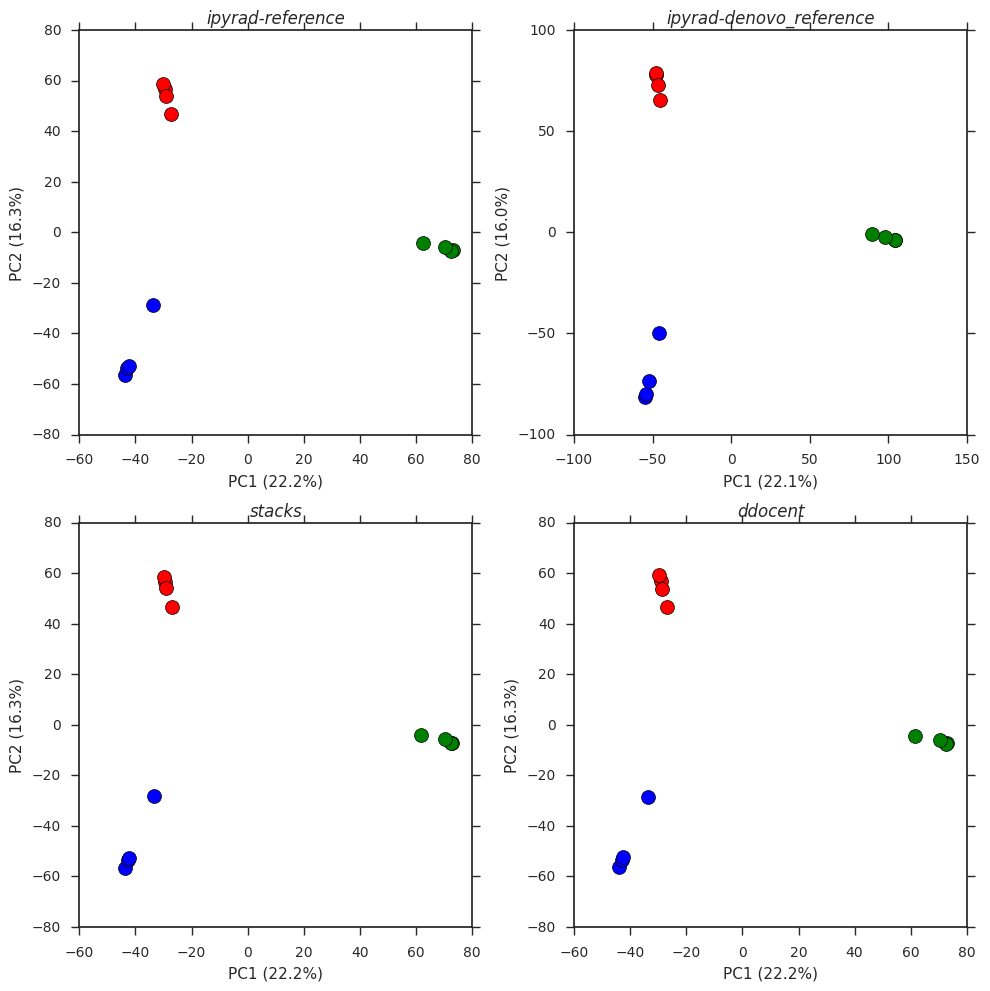

In [278]:
f, axarr = plt.subplots(2,2, figsize=(10,10), dpi=1000)
axarr = [a for b in axarr for a in b]
for prog, ax in zip(assemblers, axarr):

    coords1, model1 = getPCA(calldata[prog])

    x = coords1[:, 0]
    y = coords1[:, 1]

    ax.scatter(x, y, marker='o')
    ax.set_xlabel('PC%s (%.1f%%)' % (1, model1.explained_variance_ratio_[0]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (2, model1.explained_variance_ratio_[1]*100))

    for pop in pops.keys():
        flt = np.in1d(np.array(sim_sample_names), pops[pop])
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=pop_colors[pop], label=pop, markersize=10, mec='k', mew=.5)

    ax.set_title(prog, style="italic")
    ax.axison = True
f.tight_layout()

### Plot pairwise distances for each assembler and each simulated datatype

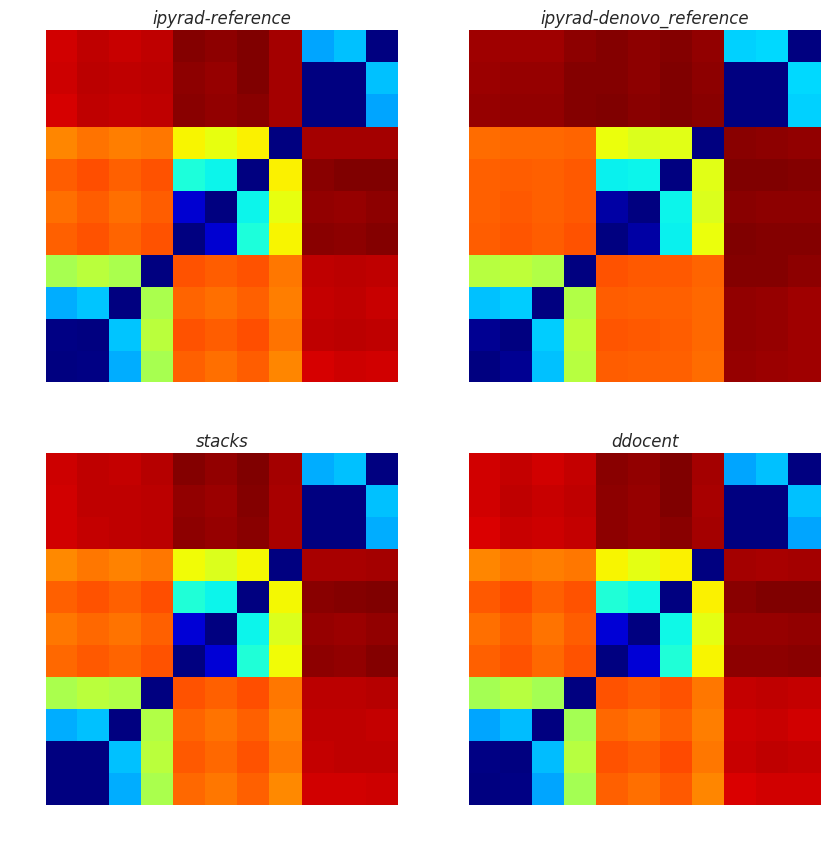

In [279]:
f, axarr = plt.subplots(2, 2, figsize=(10, 10), dpi=1000)
axarr = [a for b in axarr for a in b]
for prog, ax in zip(assemblers, axarr):

    ## Calculate pairwise distances
    dist = getDistances(calldata[prog])

    ## Doing it this way works, but allel uses imshow internally which rasterizes the image
    #allel.plot.pairwise_distance(dist, labels=None, ax=ax, colorbar=False)

    ## Create the pcolormesh by hand
    dat = ensure_square(dist)
        
    ## for some reason np.flipud(dat) is chopping off one row of data
    p = ax.pcolormesh(np.arange(0,len(dat[0])), np.arange(0,len(dat[0])), dat,\
    cmap="jet", vmin=np.min(dist), vmax=np.max(dist))
    ## Clip all heatmaps to actual sample size
    p.axes.axis("tight")

    ax.set_title(prog, style="italic")
    ax.axison = False

# Go through and pull in more fine grained results
What we want to know is total number of loci recovered (not just variable loci). First we'll create some dictionaries just like above, but we'll call them *_full_* to indicate that they include monomorphic sites. Because snps don't occur in monomorphic sites kind of by definition, we only really are iterested in the depth across loci and the number of loci recovered per sample.


In [9]:
## Blank the ordered dicts for gathering locus coverage and sample nlocs
sim_full_loc_cov = collections.OrderedDict()
sim_full_sample_nlocs = collections.OrderedDict()

## ipyrad simulated results

In [13]:
assembly_methods = {"ipyrad-reference":"refmap-sim", "ipyrad-denovo_reference":"denovo_ref-sim"}

for name, method in assembly_methods.items():
    print(method)
    simdir = os.path.join(IPYRAD_SIM_DIR, method + "_outfiles/")
    statsfile = simdir + "{}_stats.txt".format(method)
    infile = open(statsfile).readlines()
    sample_coverage = [int(x.strip().split()[1]) for x in infile[20:32]]
    print(sample_coverage)
    print("mean sample coverage - {}\t".format(np.mean(sample_coverage))),
    print("min/max - {}/{}\t".format(np.min(sample_coverage), np.max(sample_coverage)))
    sim_full_sample_nlocs[name] = sample_coverage
    
    nmissing = [int(x.strip().split()[1]) for x in infile[38:50]]
    sim_full_loc_cov[name] = nmissing

## Just look at the ones we care about for ipyrad
print(sim_full_loc_cov.items())
print(sim_full_sample_nlocs.items())

denovo_ref-sim
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
mean sample coverage - 1000.0	min/max - 1000/1000	
refmap-sim
[500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500]
mean sample coverage - 500.0	min/max - 500/500	
[('ipyrad-denovo_reference', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1000]), ('ipyrad-reference', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 500])]
[('ipyrad-denovo_reference', [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]), ('ipyrad-reference', [500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500])]


## stacks simulated results

In [14]:
method = "stacks"
simdir = STACKS_SIM_DIR
try:

    lines = open("{}/batch_1.haplotypes.tsv".format(simdir)).readlines()
    cnts = [int(field.strip().split("\t")[1]) for field in lines[1:]]
    sim_full_loc_cov[method] = [cnts.count(i) for i in range(1,13)]
except Exception as inst:
    print("loc_cov - {} - {}".format(inst, simdir))

try:
    sim_full_sample_nlocs[method] = []
    samp_haps = glob.glob("{}/*matches*".format(simdir))
    for f in samp_haps:
        lines = gzip.open(f).readlines()
        sim_full_sample_nlocs[method].append(len(lines) - 1)
except Exception as inst:
    print("sample_nlocs - {} - {}".format(inst, simdir))

print(sim_full_loc_cov.items())
print(sim_full_sample_nlocs.items())

[('ipyrad-denovo_reference', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1000]), ('ipyrad-reference', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 500]), ('stacks', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 997])]
[('ipyrad-denovo_reference', [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]), ('ipyrad-reference', [500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500]), ('stacks', [1163, 1165, 1162, 1154, 1154, 1154, 1153, 1160, 1144, 1144, 1149, 1135])]


## dDocent simulated results
It is not straightforward how to get locus coverage and nloci per sample information from ddocent results. See the manuscript-analysis notebook for more explanation about why.

In [10]:
DDOCENT_DIR = "/home/iovercast/manuscript-analysis/dDocent/"

def ddocent_stats(RUNDIR):
    ## This is hackish. You have to dip into the bam file to get locus counts that
    ## include counts for monomorphics. Note! that field 3 of the bam file is not
    ## the sequence data, but rather the dDocent mock-contig ('dDocent_Contig_3') 
    ## the read maps to. So really this is kind of by proxy counting the number of loci.
    sample_coverage = []
    for samp in glob.glob(RUNDIR + "/*-RG.bam"):
        cmd = "{}samtools view {} | cut -f 4 | uniq | wc -l".format(DDOCENT_DIR, samp)
        res = subprocess.check_output(cmd, shell=True)
        sample_coverage.append(int(res.strip()))
    print("This must be taken with a grain of salt because these aren't the actual counts you get out of the final data files.")
    print("mean sample coverage - {}".format(np.mean(sample_coverage)))
    print("min/max - {}/{}".format(np.min(sample_coverage), np.max(sample_coverage)))

    cmd = "{}samtools view {}cat-RRG.bam | cut -f 3,4 | uniq".format(DDOCENT_DIR, RUNDIR)
    locus_positions = subprocess.check_output(cmd, shell=True).split("\n")
    
    locus_counter = collections.Counter()    # Num loci per sample
    coverage_counter = collections.Counter() # Coverage per locus
    for loc in locus_positions:
        if not loc:
            continue
        chrom = loc.split()[0]
        pos = int(loc.split()[1])
        cmd = "{}samtools view {}cat-RRG.bam {}:{}-{} | cut -f 1 | cut -f 3 -d \"_\" | sort | uniq".format(DDOCENT_DIR, RUNDIR, chrom, pos, pos+1)
        res = subprocess.check_output(cmd, shell=True).split()
        locus_counter.update(res)
        coverage_counter.update([len(res)])
        ## Fill in zero values that aren't in the locus counter
        dat = []
        for i in xrange(1,13):
            try:
                dat.append(coverage_counter[i])
            except:
                dat.append(0)

    return dat, locus_counter.values()

loc_cov, sample_nlocs = ddocent_stats(DDOCENT_SIM_DIR)

sim_full_loc_cov["ddocent"] = loc_cov
sim_full_sample_nlocs["ddocent"] = sample_nlocs
print(sim_full_loc_cov.items())
print(sim_full_sample_nlocs.items())

This must be taken with a grain of salt because these aren't the actual counts you get out of the final data files.
mean sample coverage - 1000.66666667
min/max - 1000/1002
[('ddocent', [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1007])]
[('ddocent', [1007, 1007, 1007, 1007, 1007, 1007, 1007, 1008, 1008, 1007, 1007, 1007])]


## Plotting simulation results

Mean number of loci recovered per sample.
                        simulated
ipyrad-reference              500
ipyrad-denovo_reference      1000
stacks                    1153.08
ddocent                   1007.17


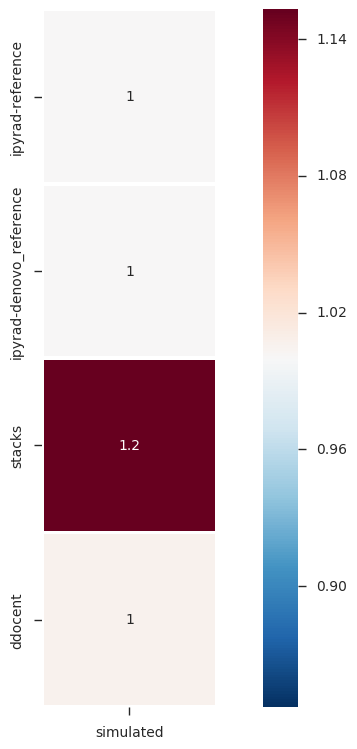

In [313]:
simlevel = ["simulated"]
sim_sample_nlocs_df = pd.DataFrame(index=assemblers, columns=simlevel)

for sim in simlevel:
    for ass in assemblers:
        simstring = ass
        sim_sample_nlocs_df[sim][ass] = np.mean(sim_full_sample_nlocs[simstring])
print("Mean number of loci recovered per sample.")
## Normalize all bins
dat = sim_sample_nlocs_df[sim_sample_nlocs_df.columns].astype(float)
for sim in simlevel:
    scale = 1000
#    if "ipyrad-reference" == sim
    dat[sim] = dat[sim]/scale
    dat[sim]["ipyrad-reference"] *= 2
sns.heatmap(dat, square=True, center=1, linewidths=2, annot=True)
print(sim_sample_nlocs_df)

### Much better! Do the spline plot version of the above plot
It just looks nicer, makes more sense.

__NB__: This is broken for refmap.

ValueError: left cannot be >= right

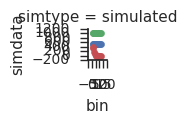

In [60]:
dfsns2 = pd.DataFrame(columns = ["assembler", "simtype", "bin", "simdata"])


for sim in simlevel:
    for ass in assemblers:
        simstring = ass
        ## Normalize values so different sim sizes print the same
        max = 1000.
        
        newdat = sim_full_loc_cov[simstring]
        newdat = [sum(newdat)-sum(newdat[:i-1]) for i in range(1,13)]
        for i, val in enumerate(newdat):
            dfsns2.loc[simstring + "-" + str(i)] = [ass, sim, i+1, val]

g = sns.FacetGrid(dfsns2, col="simtype", hue="assembler", size=1)
g.map(plt.scatter, "bin", "simdata")
g.map(plt.plot, "bin", "simdata").add_legend()
#axs = g.axes
#for ax in axs:
#    ax.set_xlim(0,12.5)

# Empirical Results (Phocoena)
This section is incomplete. See below for empirical and simulated results that are combined.

## Process the vcf output from all the runs
Here we'll pull together all the output vcf files. This takes a few minutes to run.

In [123]:
emp_vcf_dict = {}
emp_vcf_dict["ipyrad-reference"] = os.path.join(IPYRAD_REFMAP_DIR, "refmap-empirical_outfiles/refmap-empirical.vcf")
emp_vcf_dict["ipyrad-denovo_reference"] = os.path.join(IPYRAD_REFMAP_DIR, "denovo_ref-empirical_outfiles/denovo_ref-empirical.vcf")
emp_vcf_dict["stacks"] = os.path.join(STACKS_REFMAP_DIR, "batch_1.vcf")
emp_vcf_dict["ddocent"] = os.path.join(DDOCENT_REFMAP_DIR, "TotalRawSNPs.snps.vcf.recode.vcf")

## Read in vcf for each analysis and pull in coverage/depth stats

[vcfnp] 2016-12-29 22:07:19.464202 :: caching is disabled
[vcfnp] 2016-12-29 22:07:19.464703 :: building array


Doing - ipyrad-denovo_reference
	/home/iovercast/manuscript-analysis/Phocoena_empirical/ipyrad/denovo_ref-empirical_outfiles/denovo_ref-empirical.vcf
file not found: /home/iovercast/manuscript-analysis/Phocoena_empirical/ipyrad/denovo_ref-empirical_outfiles/denovo_ref-empirical.vcf
Doing - ipyrad-reference
	/home/iovercast/manuscript-analysis/Phocoena_empirical/ipyrad/refmap-empirical_outfiles/refmap-empirical.vcf
file not found: /home/iovercast/manuscript-analysis/Phocoena_empirical/ipyrad/refmap-empirical_outfiles/refmap-empirical.vcf
Doing - stacks
	/home/iovercast/manuscript-analysis/Phocoena_empirical/stacks/batch_1.vcf


[vcfnp] 2016-12-29 22:07:22.543297 :: caching is disabled
[vcfnp] 2016-12-29 22:07:22.543798 :: building array


global name 'species' is not defined


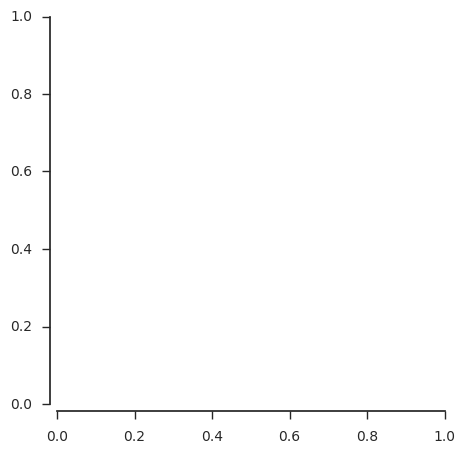

In [124]:
emp_loc_cov = collections.OrderedDict()
emp_snp_cov = collections.OrderedDict()
emp_sample_nsnps = collections.OrderedDict()
emp_sample_nlocs = collections.OrderedDict()
## Try just doing them all the same
for prog, filename in emp_vcf_dict.items():
    try:
        print("Doing - {}".format(prog))
        print("\t{}".format(filename))
        v = vcfnp.variants(filename, dtypes={"CHROM":"a24"}).view(np.recarray)
        c = vcfnp.calldata_2d(filename).view(np.recarray)

        emp_loc_cov[prog] = loci_coverage(v, c, prog)
        emp_snp_cov[prog] = snp_coverage(c)
        emp_sample_nsnps[prog] = sample_nsnps(c)
        emp_sample_nlocs[prog] = sample_nloci(v, c, prog)
        
        plotPCA(c, prog)
        plotPairwiseDistance(c, prog)
    except Exception as inst:
        print(inst)

In [608]:
for i in emp_sample_nlocs:
    print(i),
    print(emp_sample_nlocs[i])

stacks_default [22215, 32074, 25377, 16640, 23557, 17426, 32172, 34354, 31333, 29809, 34792, 24791, 25256]
ddocent_full [34816, 37668, 35523, 25583, 36635, 25751, 38051, 39179, 38946, 38744, 39209, 37612, 37240]
pyrad [22826, 34866, 30179, 19710, 19076, 21977, 36830, 36774, 37212, 29720, 38012, 35350, 31155]
ipyrad [18710, 28396, 24635, 15667, 15301, 17830, 29885, 29492, 30213, 24043, 30671, 29076, 25580]
ddocent_filt [18640, 18904, 18745, 18471, 18713, 18553, 18969, 19050, 19096, 19068, 19086, 19182, 19164]
stacks_ungapped [23103, 35494, 30792, 19377, 19547, 21469, 36663, 36949, 36703, 29789, 37968, 33544, 31931]


## ipyrad Empirical results
First we load in the variant info and call data for all the snps

In [70]:
IPYRAD_EMPIRICAL_OUTPUT=os.path.join(IPYRAD_DIR, "REALDATA/")
IPYRAD_STATS = os.path.join(IPYRAD_EMPIRICAL_OUTPUT, "REALDATA_outfiles/REALDATA_stats.txt")

infile = open(IPYRAD_STATS).readlines()
sample_coverage = [int(x.strip().split()[1]) for x in infile[20:33]]
print(sample_coverage)
print("mean sample coverage - {}".format(np.mean(sample_coverage)))
print("min/max - {}/{}".format(np.min(sample_coverage), np.max(sample_coverage)))

[21163, 31863, 27902, 20852, 17779, 23008, 33289, 33697, 35765, 29184, 35096, 38144, 34746]
mean sample coverage - 29422.1538462
min/max - 17779/38144


Read the biallelic vcf

In [71]:
filename = os.path.join(IPYRAD_EMPIRICAL_OUTPUT, "REALDATA_outfiles/REALDATA.biallelic.vcf")
# filename = vcf_dict["ipyrad"]
v = vcfnp.variants(filename).view(np.recarray)
c = vcfnp.calldata_2d(filename).view(np.recarray)

[vcfnp] 2016-10-12 12:42:26.099077 :: caching is disabled
[vcfnp] 2016-10-12 12:42:26.099836 :: building array
[vcfnp] 2016-10-12 12:42:29.441796 :: caching is disabled
[vcfnp] 2016-10-12 12:42:29.442748 :: building array


### Distribution of snps along loci
Getting variable sites and parsimony informative sites from the vcf is kind of annoying
because all the programs export __slightly__ different formats, so you need to
parse them in slightly different ways. There's a better way to do this for ipyrad
but i figure i'll do it the same way for all of them so it's more clear what's happening.

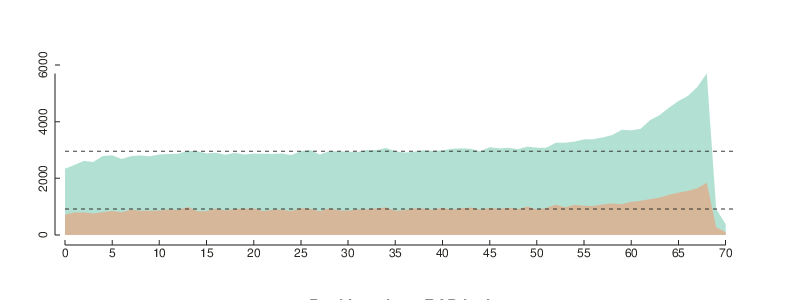

In [72]:
## Get only parsimony informative sites
## Get T/F values for whether each genotype is ref or alt across all samples/loci
is_alt_allele = map(lambda x: map(lambda y: 1 in y, x), c["genotype"])
## Count the number of alt alleles per snp (we only want to retain when #alt > 1)
alt_counts = map(lambda x: np.count_nonzero(x), is_alt_allele)
## Create a T/F mask for snps that are informative
only_pis = map(lambda x: x < 2, alt_counts)
## Apply the mask to the variant array so we can pull out the position of each snp w/in each locus
## Also, compress() the masked array so we only actually see the pis
pis = np.ma.array(np.array(v["POS"]), mask=only_pis).compressed()

## Now have to massage this into the list of counts per site in increasing order 
## of position across the locus
distpis = Counter([int(x) for x in pis])
#distpis = [x for x in sorted(counts.items())]

## Getting the distvar is easier
distvar = Counter([int(x) for x in v.POS])
#distvar = [x for x in sorted(counts.items())]

canvas, axes = SNP_position_plot(distvar, distpis)

## save fig
#toyplot.html.render(canvas, 'snp_positions.html')

canvas

## stacks empirical results

In [12]:
STACKS_OUTPUT=os.path.join(STACKS_DIR, "REALDATA/")
STACKS_GAP_OUT=os.path.join(STACKS_OUTPUT, "gapped/")
STACKS_UNGAP_OUT=os.path.join(STACKS_OUTPUT, "ungapped/")
STACKS_DEFAULT_OUT=os.path.join(STACKS_OUTPUT, "default/")

#lines = open("SIMsmall/stackf_high/batch_1.haplotypes.tsv").readlines()
#cnts = [int(field.strip().split("\t")[1]) for field in lines[1:]]
#shigh = [cnts.count(i) for i in range(1,13)]

In [13]:
filename = os.path.join(STACKS_UNGAP_OUT, "batch_1.vcf")
v = vcfnp.variants(filename).view(np.recarray)
c = vcfnp.calldata_2d(filename).view(np.recarray)

[vcfnp] 2016-10-12 10:48:17.512074 :: caching is disabled
[vcfnp] 2016-10-12 10:48:17.512879 :: building array
[vcfnp] 2016-10-12 10:48:25.055213 :: caching is disabled
[vcfnp] 2016-10-12 10:48:25.061273 :: building array


### Distribution of snps along loci

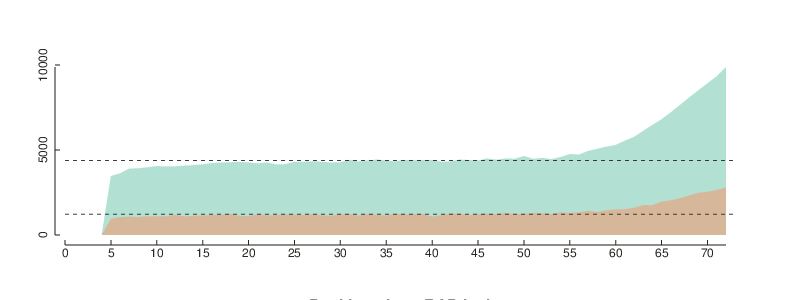

In [14]:
## Get only parsimony informative sites
## Get T/F values for whether each genotype is ref or alt across all samples/loci
is_alt_allele = map(lambda x: map(lambda y: 1 in y, x), c["genotype"])
## Count the number of alt alleles per snp (we only want to retain when #alt > 1)
alt_counts = map(lambda x: np.count_nonzero(x), is_alt_allele)
## Create a T/F mask for snps that are informative
only_pis = map(lambda x: x < 2, alt_counts)
## Apply the mask to the variant array so we can pull out the position of each snp w/in each locus
## Also, compress() the masked array so we only actually see the pis
pis = np.ma.array(np.array(v["ID"]), mask=only_pis).compressed()

## Now have to massage this into the list of counts per site in increasing order 
## of position across the locus
distpis = Counter([int(x.split("_")[1]) for x in pis])
#distpis = [x for x in sorted(counts.items())]

## Getting the distvar is easier
distvar = Counter([int(x.split("_")[1]) for x in v.ID])
#distvar = [x for x in sorted(counts.items())]

canvas, axes = SNP_position_plot(distvar, distpis)

## save fig
#toyplot.html.render(canvas, 'snp_positions.html')

canvas

# SKIP to HERE
# Do both simulated and empirical at the same time
Could make the plots prettier

In [345]:
vcf_dict = {}
vcf_dict["ipyrad-reference-sim"] = os.path.join(IPYRAD_SIM_DIR, "refmap-sim_outfiles/refmap-sim.vcf")
vcf_dict["ipyrad-denovo_plus_reference-sim"] = os.path.join(IPYRAD_SIM_DIR, "denovo_plus_reference-sim_outfiles/denovo_plus_reference-sim.vcf")
vcf_dict["ipyrad-denovo_minus_reference-sim"] = os.path.join(IPYRAD_SIM_DIR, "denovo_minus_reference-sim_outfiles/denovo_minus_reference-sim.vcf")
vcf_dict["stacks-sim"] = os.path.join(STACKS_SIM_DIR, "batch_1.vcf")
vcf_dict["ddocent-tot-sim"] = os.path.join(DDOCENT_SIM_DIR, "TotalRawSNPs.snps.vcf.recode.vcf")
vcf_dict["ddocent-fin-sim"] = os.path.join(DDOCENT_SIM_DIR, "Final.recode.snps.vcf.recode.vcf")
vcf_dict["ipyrad-reference-empirical"] = os.path.join(IPYRAD_REFMAP_DIR, "reference-assembly/refmap-empirical_outfiles/refmap-empirical.vcf")
vcf_dict["ipyrad-denovo_plus_reference-empirical"] = os.path.join(IPYRAD_REFMAP_DIR, "reference-assembly/denovo_plus_reference_outfiles/denovo_ref-empirical.vcf")
vcf_dict["ipyrad-denovo_minus_reference-empirical"] = os.path.join(IPYRAD_REFMAP_DIR, "reference-assembly/denovo_minus_reference_outfiles/denovo_ref-empirical.vcf")
vcf_dict["stacks-empirical"] = os.path.join(STACKS_REFMAP_DIR, "batch_1.vcf")
vcf_dict["ddocent-fin-empirical"] = os.path.join(DDOCENT_REFMAP_DIR, "Final.recode.snps.vcf.recode.vcf")

# skipt the full ddocent vcf. It's huge and we know we don't want to use it.
#vcf_dict["ddocent-tot-empirical"] = os.path.join(DDOCENT_REFMAP_DIR, "TotalRawSNPs.snps.vcf.recode.vcf")

## Make sure we have all the vcf files
for k, f in vcf_dict.items():
    if os.path.exists(f):
        print("found - {}".format(f))
    else:
        print("not found - {}".format(f))

found - /home/iovercast/manuscript-analysis/REFMAP_SIM/ddocent/Final.recode.snps.vcf.recode.vcf
found - /home/iovercast/manuscript-analysis/Phocoena_empirical/stacks/batch_1.vcf
found - /home/iovercast/manuscript-analysis/REFMAP_SIM/ipyrad/reference-assembly/denovo_minus_reference-sim_outfiles/denovo_minus_reference-sim.vcf
not found - /home/iovercast/manuscript-analysis/Phocoena_empirical/ipyrad/reference-assembly/denovo_plus_reference_outfiles/denovo_ref-empirical.vcf
found - /home/iovercast/manuscript-analysis/REFMAP_SIM/stacks/batch_1.vcf
found - /home/iovercast/manuscript-analysis/Phocoena_empirical/ipyrad/reference-assembly/refmap-empirical_outfiles/refmap-empirical.vcf
found - /home/iovercast/manuscript-analysis/Phocoena_empirical/ipyrad/reference-assembly/denovo_minus_reference_outfiles/denovo_ref-empirical.vcf
found - /home/iovercast/manuscript-analysis/Phocoena_empirical/ddocent/Final.recode.snps.vcf.recode.vcf
found - /home/iovercast/manuscript-analysis/REFMAP_SIM/ddocent/To

### Some magic to get samples and populations properly grouped and colored for pretty PCA plots
There has got to be a better way to do this for the empirical at least. It seems super hax, but it works.

In [56]:
## sim
pop1 = ["1A_0", "1B_0", "1C_0", "1D_0"]
pop2 = ["2E_0", "2F_0", "2G_0", "2H_0"]
pop3 = ["3I_0", "3J_0", "3K_0", "3L_0"]
sim_sample_names = pop1 + pop2 + pop3
sim_pops = {"pop1":pop1, "pop2":pop2, "pop3":pop3}
sim_pop_colors = {"pop1":"r", "pop2":"b", "pop3":"g"}

## empirical
emp_pops = {}
emp_sample_names = []
popfile = os.path.join(STACKS_REFMAP_DIR, "popmap.txt")
with open(popfile) as infile:
    lines = [l.strip().split() for l in infile.readlines()]
    emp_sample_names = [x[0] for x in lines]
    pops = set([x[1] for x in lines])
    for pop in pops: emp_pops[pop] = []
    for line in lines:
        p = line[1]
        s = line[0]
        emp_pops[p].append(s)
emp_pop_colors = {k:v for (k,v) in zip(emp_pops, list(matplotlib.colors.cnames))}

## Write out the samples to pop files for vcftools
for outdir, pop_dict in {REFMAP_SIM_DIR:sim_pops, REFMAP_EMPIRICAL_DIR:emp_pops}.items():
    for pop, samps in pop_dict.items():
        with open(outdir + pop + ".txt", "w") as outfile:
            outfile.write("\n".join(samps))

In [343]:
## The order of the samples in the vcf file is wonky. Reorder them so they're sorted by population. This
## is roughly the order of populations from the manuscript.

## If you run this multiple times, you should re-run the previous cell that resets
## the vcf file to the original path, otherwise you get a bunch of *.reorder.reorder.vcf files.
order = ["WBS", "IS", "NOS", "SK1", "KB1", "BES2", "IBS"]

vcf_header = """##fileformat=VCFv4.1\n##fileDate=20161230\n##source="Stacks v1.42"\n##INFO=<ID=NS,Number=1,Type=Integer,Description="Number of Samples With Data">\n##INFO=<ID=AF,Number=.,Type=Float,Description="Allele Frequency">\n##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">\n##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Read Depth">\n##FORMAT=<ID=AD,Number=1,Type=Integer,Description="Allele Depth">\n##FORMAT=<ID=GL,Number=.,Type=Float,Description="Genotype Likelihood">\n#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\tFORMAT"""
with open("/tmp/dummy.vcf", 'w') as outfile:
    outfile.write(vcf_header)
    for p in order:
        outfile.write("\t" + "\t".join(emp_pops[p]))
for k, f in vcf_dict.items():
    if "stacks" in k:
        ## The version of vcftools we have here doesn't like the newer version of vcf stacks
        ## writes, so we have to 'fix' the stacks vcf version
        print("Fixing stacks vcf file format - {}".format(k))
        shutil.copy2(f, f+".bak")
        with open(f) as infile:
            dat = infile.readlines()[1:]
        with open(f, 'w') as outfile:
            outfile.write("##fileformat=VCFv4.1\n")
            outfile.write("".join(dat))
    ## skip reordering to see if it fixes the pca plots
    continue
    if "empirical" in k:
        print("reordering")
        vcftools_path = os.path.join(DDOCENT_DIR, "vcftools_0.1.11/perl/")
        os.chdir(vcftools_path)
        tmpvcf = "tmp.vcf"
        newvcf = f.rsplit(".", 1)[0] + ".reordered.vcf"
        print(newvcf)
        cmd = "perl vcf-shuffle-cols -t {} {} > {}".format("/tmp/dummy.vcf", f, tmpvcf)
        print(cmd)
        os.system(cmd)
        !mv $tmpvcf $newvcf
        ## Don't destroy the old one
        vcf_dict[k] = newvcf

Fixing stacks vcf file format - stacks-empirical
Fixing stacks vcf file format - stacks-sim


In [346]:
import collections
## Load the calldata into a dict so we don't have to keep loading and reloading it
## This can take several minutes for the large empirical datasets (like 20+ minutes)
all_calldata = {}
all_vardata = {}

## Dicts for tracking all the stats
loc_cov = collections.OrderedDict()
snp_cov = collections.OrderedDict()
samp_nsnps = collections.OrderedDict()
samp_nlocs = collections.OrderedDict()

for prog, filename in vcf_dict.items():
    try:
        print("Doing - {}\n  {}".format(prog, filename))
        v = vcfnp.variants(filename, verbose=False, dtypes={"CHROM":"a24"}).view(np.recarray)
        c = vcfnp.calldata_2d(filename, verbose=False).view(np.recarray)
        all_calldata[prog] = c
        all_vardata[prog] = v
        
        snp_cov[prog] = snp_coverage(c)
        samp_nsnps[prog] = sample_nsnps(c)
        loc_cov[prog] = loci_coverage(v, c, prog)
        samp_nlocs[prog] = sample_nloci(v, c, prog)
    except Exception as inst:
        print(inst)

Doing - ddocent-fin-sim
  /home/iovercast/manuscript-analysis/REFMAP_SIM/ddocent/Final.recode.snps.vcf.recode.vcf
Doing - stacks-empirical
  /home/iovercast/manuscript-analysis/Phocoena_empirical/stacks/batch_1.vcf
Doing - ipyrad-denovo_minus_reference-sim
  /home/iovercast/manuscript-analysis/REFMAP_SIM/ipyrad/reference-assembly/denovo_minus_reference-sim_outfiles/denovo_minus_reference-sim.vcf
Doing - ipyrad-denovo_plus_reference-empirical
  /home/iovercast/manuscript-analysis/Phocoena_empirical/ipyrad/reference-assembly/denovo_plus_reference_outfiles/denovo_ref-empirical.vcf
file not found: /home/iovercast/manuscript-analysis/Phocoena_empirical/ipyrad/reference-assembly/denovo_plus_reference_outfiles/denovo_ref-empirical.vcf
Doing - stacks-sim
  /home/iovercast/manuscript-analysis/REFMAP_SIM/stacks/batch_1.vcf
Doing - ipyrad-reference-empirical
  /home/iovercast/manuscript-analysis/Phocoena_empirical/ipyrad/reference-assembly/refmap-empirical_outfiles/refmap-empirical.vcf
Doing - ip

In [30]:
for statname, stat in {"loc_cov":loc_cov, "snp_cov":snp_cov,\
             "sample_nsnps":samp_nsnps, "sample_nlocs":samp_nlocs}.items():
    for prog in vcf_dict.keys():
        try:
            print(prog + " " + statname + "\t"),
            print(stat[prog]),
            print(np.mean(stat[prog]))
        except:
            print("No {} stats for {}".format(statname, prog))
    print("------------------------------------------------------")

stacks-empirical sample_nlocs	[78511, 81962, 82414, 94151, 92146, 104316, 94099, 83252, 93109, 88319, 92008, 45195, 36564, 37502, 97311, 97110, 96071, 98059, 86883, 79414, 97308, 92421, 70530, 85021, 81766, 91929, 87529, 95557, 87105, 65463, 93372, 84925, 46207, 98960, 78322, 91547, 98216, 57176, 26729, 68932, 83942, 110102, 50223, 81625] 81438.7045455
ipyrad-denovo_plus_reference-empirical sample_nlocs	No sample_nlocs stats for ipyrad-denovo_plus_reference-empirical
stacks-sim sample_nlocs	[994, 993, 994, 993, 994, 994, 994, 994, 994, 994, 994, 994] 993.833333333
ipyrad-reference-empirical sample_nlocs	[31030, 33423, 33693, 37242, 36927, 39491, 38589, 31674, 37857, 35265, 37421, 18602, 14897, 13209, 39165, 38832, 39065, 36030, 35081, 32160, 38806, 37707, 28368, 34076, 29465, 37217, 33201, 38057, 35794, 25000, 37581, 32377, 18832, 38576, 28166, 35939, 39433, 22276, 8975, 27358, 34143, 43137, 17783, 32452] 32144.8181818
ipyrad-denovo_minus_reference-empirical sample_nlocs	[30955, 33398,

## Filter linked snps? Doesn't make a difference.

('ipyrad-reference-sim', <matplotlib.axes._subplots.AxesSubplot object at 0x2aabf9097750>)
('ipyrad-denovo_plus_reference-sim', <matplotlib.axes._subplots.AxesSubplot object at 0x2aaba9f4e2d0>)
('ipyrad-denovo_minus_reference-sim', <matplotlib.axes._subplots.AxesSubplot object at 0x2aabf81cd8d0>)
('stacks-sim', <matplotlib.axes._subplots.AxesSubplot object at 0x2aaba9e54210>)
('ddocent-fin-sim', <matplotlib.axes._subplots.AxesSubplot object at 0x2aaba9dc9650>)
('ipyrad-reference-empirical', <matplotlib.axes._subplots.AxesSubplot object at 0x2aaba9d641d0>)
('ipyrad-denovo_reference-empirical', <matplotlib.axes._subplots.AxesSubplot object at 0x2aaba9a4e9d0>)
('ipyrad-denovo_minus_reference-empirical', <matplotlib.axes._subplots.AxesSubplot object at 0x2aaba9c6b790>)
('stacks-empirical', <matplotlib.axes._subplots.AxesSubplot object at 0x2aaba9c278d0>)
('ddocent-fin-empirical', <matplotlib.axes._subplots.AxesSubplot object at 0x2aabf8125310>)


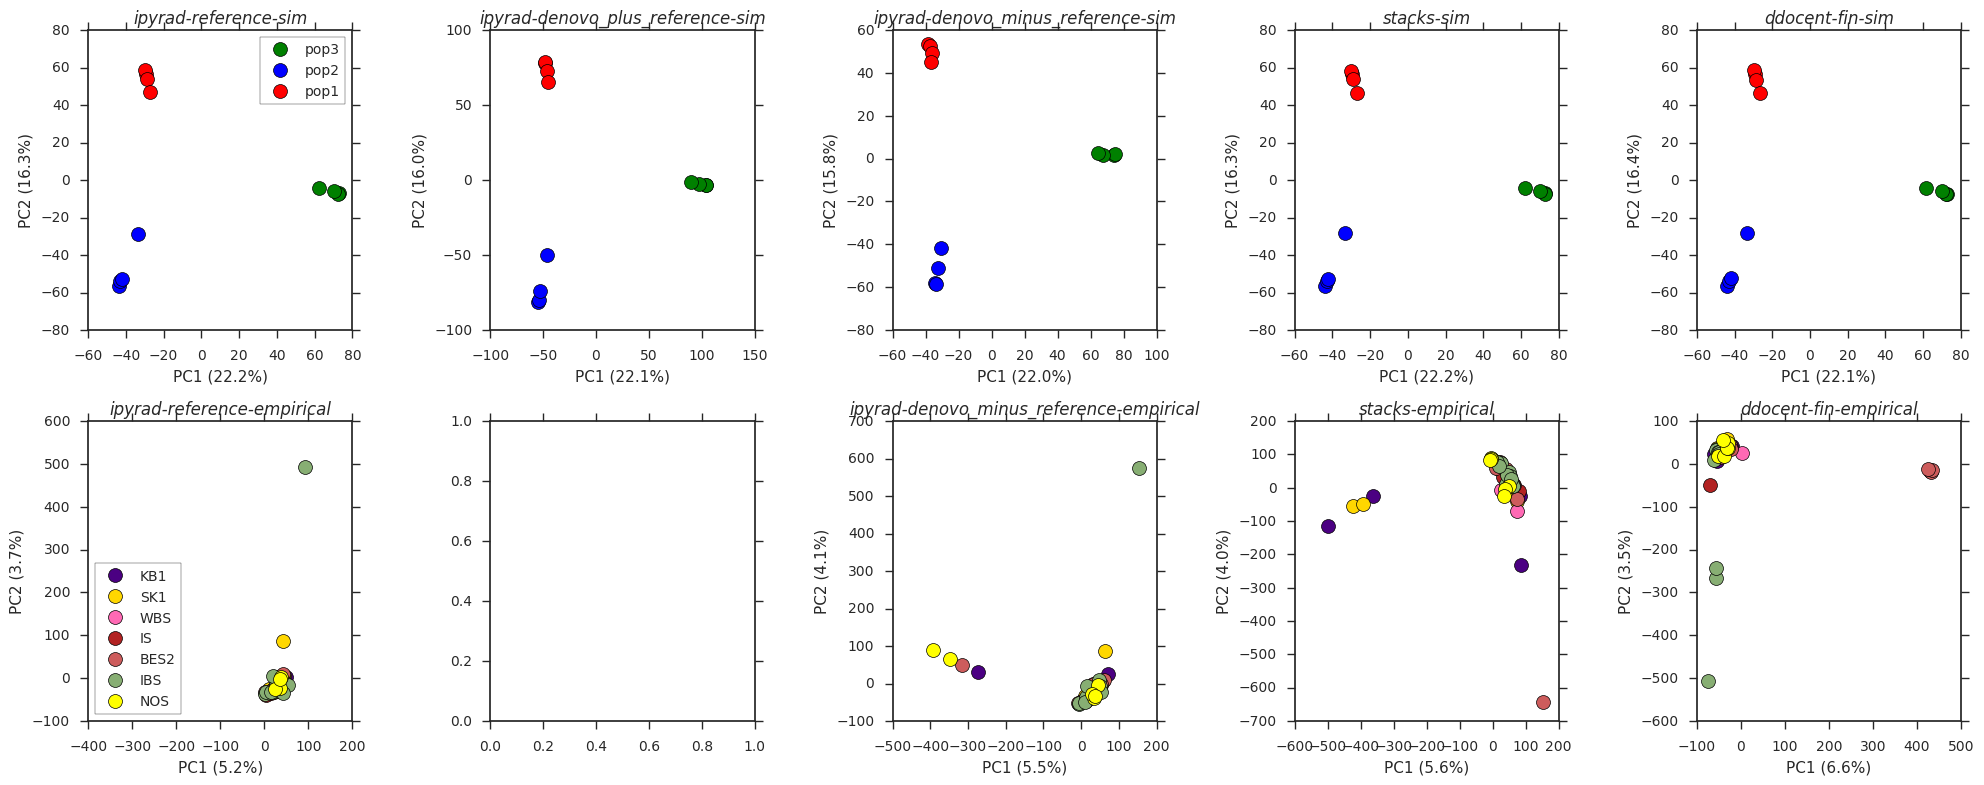

In [347]:
f, axarr = plt.subplots(2, 5, figsize=(20,8), dpi=1000)
## Make a list out of the axes
axarr = [a for b in axarr for a in b]
## Set them in order so the plot looks nice.
progs = ["ipyrad-reference-sim", "ipyrad-denovo_plus_reference-sim", "ipyrad-denovo_minus_reference-sim", "stacks-sim", "ddocent-fin-sim",\
         "ipyrad-reference-empirical", "ipyrad-denovo_reference-empirical", "ipyrad-denovo_minus_reference-empirical", "stacks-empirical", "ddocent-fin-empirical"]

for prog, ax in zip(progs, axarr):
    print(prog, ax)
    if "empirical" in prog:
        pop_colors = emp_pop_colors
        pops = emp_pops
        sample_names = emp_sample_names
    else:
        pop_colors = sim_pop_colors
        pops = sim_pops
        sample_names = sim_sample_names
    ## Don't die if some of the runs aren't complete
    try:
        coords1, model1 = getPCA(all_calldata[prog])
    except:
        continue
        
    x = coords1[:, 0]
    y = coords1[:, 1]

    ax.scatter(x, y, marker='o')
    ax.set_xlabel('PC%s (%.1f%%)' % (1, model1.explained_variance_ratio_[0]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (2, model1.explained_variance_ratio_[1]*100))

    for pop in pops.keys():
        flt = np.in1d(np.array(sample_names), pops[pop])
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=pop_colors[pop], label=pop, markersize=10, mec='k', mew=.5)

    ax.set_title(prog, style="italic")
    ax.axison = True

axarr[0].legend(frameon=True)
axarr[5].legend(loc='lower left', frameon=True)

f.tight_layout()

('ipyrad-reference-sim', <matplotlib.axes._subplots.AxesSubplot object at 0x2aabf9174f90>)
('ipyrad-denovo_plus_reference-sim', <matplotlib.axes._subplots.AxesSubplot object at 0x2aaba1c8c2d0>)
('ipyrad-denovo_minus_reference-sim', <matplotlib.axes._subplots.AxesSubplot object at 0x2aaba1adc750>)
('stacks-sim', <matplotlib.axes._subplots.AxesSubplot object at 0x2aaba1567650>)
('ddocent-fin-sim', <matplotlib.axes._subplots.AxesSubplot object at 0x2aaba1204ad0>)
('ipyrad-reference-empirical', <matplotlib.axes._subplots.AxesSubplot object at 0x2aaba125d2d0>)
('ipyrad-denovo_reference-empirical', <matplotlib.axes._subplots.AxesSubplot object at 0x2aaba12eb750>)
('ipyrad-denovo_minus_reference-empirical', <matplotlib.axes._subplots.AxesSubplot object at 0x2aaba136c5d0>)
('stacks-empirical', <matplotlib.axes._subplots.AxesSubplot object at 0x2aaba13da290>)
('ddocent-fin-empirical', <matplotlib.axes._subplots.AxesSubplot object at 0x2aaba145d610>)


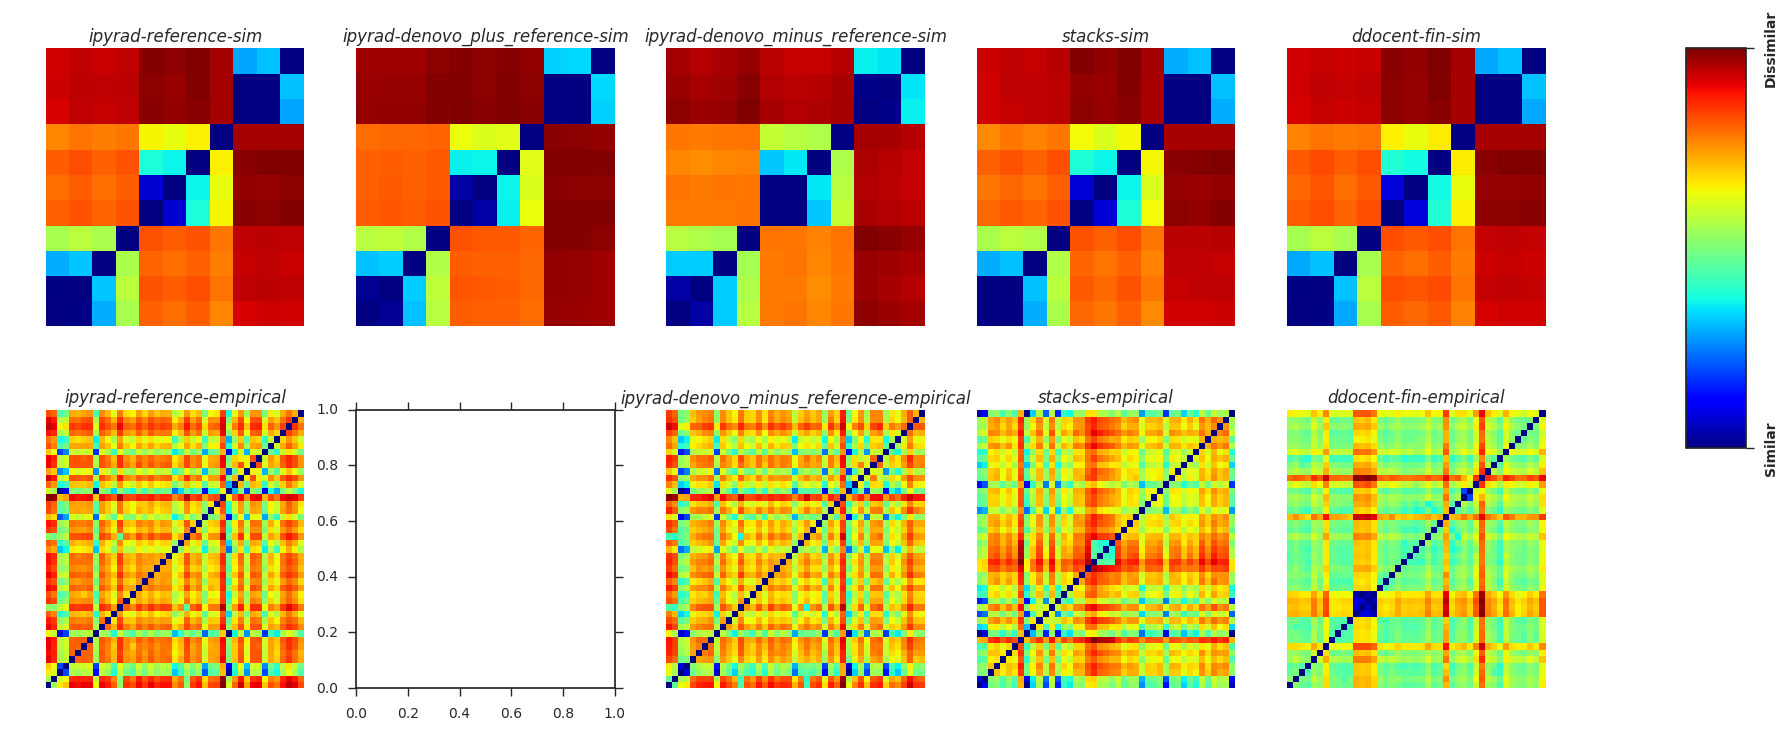

In [348]:
f, axarr = plt.subplots(2, 5, figsize=(20,8), dpi=1000)
axarr = [a for b in axarr for a in b]
## Set them in order so the plot looks nice.
progs = ["ipyrad-reference-sim", "ipyrad-denovo_plus_reference-sim", "ipyrad-denovo_minus_reference-sim", "stacks-sim", "ddocent-fin-sim",\
         "ipyrad-reference-empirical", "ipyrad-denovo_reference-empirical", "ipyrad-denovo_minus_reference-empirical", "stacks-empirical", "ddocent-fin-empirical"]

for prog, ax in zip(progs, axarr):
    print(prog, ax)
    try:
        ## Calculate pairwise distances
        dist = getDistances(all_calldata[prog])
    except:
        continue

    ## Create the pcolormesh by hand
    dat = ensure_square(dist)
        
    ## for some reason np.flipud(dat) is chopping off one row of data
    p = ax.pcolormesh(np.arange(0,len(dat[0])), np.arange(0,len(dat[0])), dat,\
    cmap="jet", vmin=np.min(dist), vmax=np.max(dist))
    ## Clip all heatmaps to actual sample size
    p.axes.axis("tight")

    ax.set_title(prog, style="italic")
    ax.axison = False

## Adjust margins to make room for the colorbar
plt.subplots_adjust(left=0.05, bottom=0.1, right=0.8, top=0.9, wspace=0.2, hspace=0.3)

## Add the colorbar
cax = f.add_axes([0.87, 0.4, 0.03, 0.5])
cb1 = matplotlib.colorbar.ColorbarBase(cax, cmap="jet", orientation="vertical", ticks=([0,1]))
cb1.ax.set_yticklabels(['Similar', "Dissimilar"], weight="bold", rotation="vertical")

## Pull in finer grained stats for each assembler
For ipyrad and stacks this is very quick, but the whole step is slow because ddocent empirical
stats take _forever_ to obtain.

In [49]:
## Blank the ordered dicts for gathering locus coverage and sample nlocs
all_full_loc_cov = collections.OrderedDict()
all_full_sample_nlocs = collections.OrderedDict()

## Mapping between 'pretty names' and directory names. This is only really useful for ipyrad
## where i named the directories a little silly. For stacks and ddocent this doesn't really do anything.
assembly_methods = {"ipyrad-reference-sim":"refmap-sim", "ipyrad-denovo_reference-sim":"denovo_ref-sim",\
                    "stacks-sim":"stacks-sim", "ipyrad-reference-empirical":"refmap-empirical",\
                    "stacks-empirical":"stacks-empirical", "ddocent-simulated":"ddocent-simulated",\
                    "ddocent-empirical":"ddocent-empirical",\
                    "ipyrad_denovo_minus_reference-sim":"denovo_minus_reference-sim",\
                    "ipyrad_denovo_plus_reference-sim":"denovo_plus_reference-sim",\
                    "ipyrad_denovo_minus_reference-empirical":"denovo_minus_reference",\
                    "ipyrad_denovo_plus_reference-empirical":"denovo_plus_reference"
                   }

for name, method in assembly_methods.items():
    print("Doing - {}".format(name))
    if "ipyrad" in name:
        outdir = IPYRAD_SIM_DIR
        firstsamp = 20
        lastsamp = 32
        if "empirical" in name:
            outdir = IPYRAD_REFMAP_DIR + "reference-assembly/"
            firstsamp = 20 #fixme
            lastsamp = 64 # fixme
        try:
            nsamps = lastsamp - firstsamp
            simdir = os.path.join(outdir, method + "_outfiles/")
            statsfile = simdir + "{}_stats.txt".format(method)
            infile = open(statsfile).readlines()
            sample_coverage = [int(x.strip().split()[1]) for x in infile[firstsamp:lastsamp]]
            print("mean sample coverage - {}\t".format(np.mean(sample_coverage))),
            print("min/max - {}/{}\t".format(np.min(sample_coverage), np.max(sample_coverage)))
            all_full_sample_nlocs[name] = sample_coverage

            nmissing = [int(x.strip().split()[1]) for x in infile[lastsamp+6:lastsamp+6+nsamps]]
            all_full_loc_cov[name] = nmissing
        except Exception as inst:
            print(inst)
    elif "stacks" in name:
        outdir = STACKS_SIM_DIR
        nsamps = 12
        if "empirical" in name:
            outdir = STACKS_REFMAP_DIR
            nsamps = 44
        try:
            ## Effectively the same as thisjjjj
            ## cut -f 2 batch_1.haplotypes.tsv | sort -n | uniq -c | less
            lines = open("{}/batch_1.haplotypes.tsv".format(outdir)).readlines()
            cnts = [int(field.strip().split("\t")[1]) for field in lines[1:]]
            all_full_loc_cov[method] = [cnts.count(i) for i in range(1,nsamps+1)]
        except Exception as inst:
            print("loc_cov - {} - {}".format(inst, simdir))

        try:
            all_full_sample_nlocs[method] = []
            ## This is actually number of loci
            ## cut -f 3 *matches | sort -n | uniq | wc -l
            
            ## Right now this is actually counting number of snps
            samp_haps = glob.glob("{}/*matches*".format(outdir))
            for f in samp_haps:
                lines = gzip.open(f).readlines()
                all_full_sample_nlocs[method].append(len(lines) - 1)
    except Exception as inst:
            print("sample_nlocs - {} - {}".format(inst, outdir))
#    elif "ddocent" in name:
#        outdir = DDOCENT_SIM_DIR
#        if "empirical" in name:
#            outdir = DDOCENT_REFMAP_DIR
#        loc_cov, sample_nlocs = ddocent_stats(outdir)
#        all_full_loc_cov[method] = loc_cov
#        all_full_sample_nlocs[method] = sample_nlocs
    else:
        print("wtf?")
    try:
        print(all_full_loc_cov[name])
        print(all_full_sample_nlocs[name])
    except:
        print("no data for - {}".format(name))
        pass
    print("Done - {}\n\n".format(name))
print(all_full_loc_cov.items())
print(all_full_sample_nlocs.items())

Doing - stacks-empirical
[44367, 19212, 12649, 9571, 7961, 6694, 5997, 5625, 5210, 5136, 4765, 4653, 4400, 4499, 4465, 4347, 4215, 4264, 4418, 4501, 4596, 4603, 4712, 4891, 5055, 5402, 5737, 6002, 6479, 6757, 7147, 7807, 8294, 9141, 9957, 10916, 11935, 12668, 14520, 15065, 15006, 13576, 9744, 6215]
[321973, 346480, 312450, 353761, 406143, 333570, 294514, 327705, 342850, 335347, 351034, 330976, 279661, 345149, 331976, 216198, 307288, 327835, 312977, 364989, 231650, 360533, 344603, 288889, 374219, 339563, 251650, 295388, 427019, 315171, 353471, 336082, 343184, 208747, 331309, 352628, 363792, 180628, 318019, 255977, 362677, 310417, 390315, 238011]
Done - stacks-empirical


Doing - stacks-sim
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 997]
[1163, 1165, 1162, 1154, 1154, 1154, 1153, 1160, 1144, 1144, 1149, 1135]
Done - stacks-sim


Doing - ddocent-simulated
wtf?
no data for - ddocent-simulated
Done - ddocent-simulated


Doing - ipyrad_denovo_plus_reference-sim
mean sample coverage - 1000.0	min/max -

## Get pairwise fst for each population for simulated and empirical
Using vcftools just to get the mean fst between each population pair.

In [83]:
import itertools
## dict for storing fst values. This is a dict of dictionaries. The top level is for
## each assembly type and within each assembly type is a dict of pop pairs and the fst between them.
fsts = {}

## Get pairwise fst for each pop for sim and empirical
d = {REFMAP_SIM_DIR:sim_pops, REFMAP_EMPIRICAL_DIR:emp_pops}
for k, v in vcf_dict.items():
    if not os.path.exists(v):
        continue
    if "sim" in k:
        indir = REFMAP_SIM_DIR
        pop_dict = sim_pops
    else:
        indir = REFMAP_EMPIRICAL_DIR
        pop_dict = emp_pops
    os.chdir(indir)

    print("Doing - {}".format(k))
    fsts[k] = {}
    combinations = list(itertools.combinations(pop_dict, 2))
    for pair in combinations:
        pop1 = indir + pair[0] + ".txt"
        pop2 = indir + pair[1] + ".txt"
        vcftools_cmd = DDOCENT_DIR + "vcftools"
        cmd = "{} --vcf {} --weir-fst-pop {} --weir-fst-pop {} --out {}".format(vcftools_cmd, v, pop1, pop2, k)
        ret = subprocess.check_output(cmd, shell=True)
        ret = ret.split("\n")
        ## Get the mean fst from the output
        fst = [x for x in ret if "Weir and Cockerham mean" in x][0].split(": ")[1]
        weighted_fst = [x for x in ret if "Weir and Cockerham weighted" in x][0].split(": ")[1]
        print("-".join(pair), "{}/{}".format(fst, weighted_fst)), 
        fsts[k]["-".join(pair)] = "{}/{}".format(fst, weighted_fst)
    print("\n")


Doing - stacks-empirical
('KB1-SK1', '-0.01716/0.0033872') ('KB1-WBS', '0.076575/0.19859') ('KB1-IS', '-0.018957/0.01089') ('KB1-BES2', '-0.012275/0.0067543') ('KB1-IBS', '-0.014075/0.0045256') ('KB1-NOS', '-0.010345/0.014532') ('SK1-WBS', '0.081251/0.19717') ('SK1-IS', '-0.02681/0.0029578') ('SK1-BES2', '-0.0074286/0.013508') ('SK1-IBS', '-0.012173/0.008697') ('SK1-NOS', '-0.018733/0.0054864') ('WBS-IS', '0.11216/0.21698') ('WBS-BES2', '0.059879/0.19404') ('WBS-IBS', '0.059164/0.18995') ('WBS-NOS', '0.086069/0.20544') ('IS-BES2', '-0.0093259/0.026361') ('IS-IBS', '-0.016882/0.01746') ('IS-NOS', '-0.02235/0.0066823') ('BES2-IBS', '-0.0087638/0.0076244') ('BES2-NOS', '-0.0032056/0.024965') ('IBS-NOS', '-0.0087328/0.018391') Doing - ipyrad-denovo_minus_reference-sim
('pop3-pop2', '0.1668/0.4316') ('pop3-pop1', '0.17018/0.44182') ('pop2-pop1', '0.12268/0.32948') Doing - stacks-sim
('pop3-pop2', '0.17523/0.45058') ('pop3-pop1', '0.17249/0.45133') ('pop2-pop1', '0.12079/0.33051') Doing - ip

In [156]:
from IPython.display import display
import pandas as pd

## Organize and pretty print the fsts dict

df_sim = pd.DataFrame(index=sim_pops.keys(), columns=sim_pops.keys(), dtype=str).fillna("")
df_emp = pd.DataFrame(index=emp_pops.keys(), columns=emp_pops.keys(), dtype=str).fillna("")
for assembler, all_data in fsts.items():
    print("{}".format(assembler))
    if "sim" in assembler:
        indir = REFMAP_SIM_DIR
        pop_dict = sim_pops
        df = df_sim
    else:
        indir = REFMAP_EMPIRICAL_DIR
        pop_dict = emp_pops
        df = df_emp
    ## Init the diagonal
    for p in pop_dict.keys():
        df[p][p] = ""
    for p, fst_data in all_data.items():
        #print(df)
        p1 = p.split("-")[0]
        p2 = p.split("-")[1]
        df[p1][p2] += " "+fst_data.split("/")[0][:6]
        df[p2][p1] += " "+fst_data.split("/")[1][:6]
pd.set_option('display.max_colwidth',800)
pd.set_option('display.width',80)
df_sim.style.set_properties(**{'max-width':'10px'})
display(df_sim)
display(df_emp)

stacks-empirical
ipyrad-reference-sim
ipyrad-denovo_minus_reference-sim
ipyrad-reference-empirical
ipyrad-denovo_minus_reference-empirical
ddocent-fin-empirical
ddocent-tot-empirical
stacks-sim
ddocent-sim
ipyrad-denovo_plus_reference-sim


,pop3,pop2,pop1
pop3,,0.4503 0.4316 0.4505 0.4503 0.4410,0.4502 0.4418 0.4513 0.4506 0.4459
pop2,0.1750 0.1668 0.1752 0.1751 0.1709,,0.3291 0.3294 0.3305 0.3301 0.3293
pop1,0.1718 0.1701 0.1724 0.1721 0.1710,0.1203 0.1226 0.1207 0.1207 0.1214,


,KB1,SK1,WBS,IS,BES2,IBS,NOS
KB1,,0.0033 0.0068 0.0036 0.0029 0.0012,0.1985 0.2192 0.2548 0.1971 0.1844,0.0108 0.0140 0.0141 0.0090 0.0089,0.0067 0.0044 0.0026 0.0029 0.0030,0.0045 0.0026 0.0043 0.0033 0.0025,0.0145 0.0225 0.0145 0.0111 0.0115
SK1,-0.017 -0.024 -0.024 -0.001 -0.027,,0.1971 0.2207 0.2423 0.1961 0.1838,0.0029 0.0091 0.0047 0.0021 0.0017,0.0135 0.0195 0.0193 0.0120 0.0139,0.0086 0.0127 0.0143 0.0062 0.0091,0.0054 0.0108 0.0073 0.0053 0.0048
WBS,0.0765 0.0616 0.0897 0.0855 0.0522,0.0812 0.0726 0.0887 0.0894 0.0567,,0.2169 0.2460 0.2721 0.2216 0.2116,0.1940 0.2138 0.2298 0.1915 0.1748,0.1899 0.2042 0.2306 0.1846 0.1683,0.2054 0.2335 0.2564 0.1920 0.1832
IS,-0.018 -0.029 -0.023 -0.001 -0.033,-0.026 -0.034 -0.033 -0.007 -0.037,0.1121 0.1070 0.1295 0.1285 0.0942,,0.0263 0.0316 0.0329 0.0199 0.0204,0.0174 0.0175 0.0264 0.0116 0.0110,0.0066 0.0094 0.0079 0.0062 0.0079
BES2,-0.012 -0.022 -0.022 0.0002 -0.024,-0.007 -0.018 -0.011 0.0073 -0.019,0.0598 0.0405 0.0568 0.0731 0.0310,-0.009 -0.024 -0.016 0.0085 -0.030,,0.0076 0.0115 0.0100 0.0040 0.0044,0.0249 0.0316 0.0270 0.0197 0.0208
IBS,-0.014 -0.023 -0.022 5.1773 -0.024,-0.012 -0.022 -0.015 0.0026 -0.022,0.0591 0.0403 0.0610 0.0673 0.0274,-0.016 -0.031 -0.021 0.0012 -0.036,-0.008 -0.017 -0.015 0.0014 -0.016,,0.0183 0.0202 0.0219 0.0151 0.0172
NOS,-0.010 -0.015 -0.017 0.0038 -0.020,-0.018 -0.025 -0.025 -0.000 -0.026,0.0860 0.0749 0.0990 0.0833 0.0536,-0.022 -0.032 -0.027 -0.003 -0.033,-0.003 -0.011 -0.010 0.0119 -0.015,-0.008 -0.017 -0.014 0.0082 -0.017,


# TESTING - Everything below here is crap

## Quick and dirty raxml trees
ipyrad and stacks both kindly write out phylip files, but ddocent doesn't, so we'll have to make one ourselves.

In [177]:
%%bash -s "$WORK_DIR"
## Install raxml
mkdir $1/miniconda/src
cd $1/miniconda/src
git clone https://github.com/stamatak/standard-RAxML.git
cd standard-RAxML
make -f Makefile.PTHREADS.gcc
cp raxml-PTHREADS $1/miniconda/bin

rm -f *.o raxmlHPC-PTHREADS-AVX2
gcc  -D_USE_PTHREADS  -D__SIM_SSE3 -O2 -D_GNU_SOURCE -msse3 -fomit-frame-pointer -funroll-loops  -D__AVX    -c -o axml.o axml.c
gcc  -D_USE_PTHREADS  -D__SIM_SSE3 -O2 -D_GNU_SOURCE -msse3 -fomit-frame-pointer -funroll-loops  -D__AVX    -c -o optimizeModel.o optimizeModel.c
gcc  -D_USE_PTHREADS  -D__SIM_SSE3 -O2 -D_GNU_SOURCE -msse3 -fomit-frame-pointer -funroll-loops  -D__AVX    -c -o multiple.o multiple.c
gcc  -D_USE_PTHREADS  -D__SIM_SSE3 -O2 -D_GNU_SOURCE -msse3 -fomit-frame-pointer -funroll-loops  -D__AVX    -c -o searchAlgo.o searchAlgo.c
gcc  -D_USE_PTHREADS  -D__SIM_SSE3 -O2 -D_GNU_SOURCE -msse3 -fomit-frame-pointer -funroll-loops  -D__AVX    -c -o topologies.o topologies.c
gcc  -D_USE_PTHREADS  -D__SIM_SSE3 -O2 -D_GNU_SOURCE -msse3 -fomit-frame-pointer -funroll-loops  -D__AVX    -c -o parsePartitions.o parsePartitions.c
gcc  -D_USE_PTHREADS  -D__SIM_SSE3 -O2 -D_GNU_SOURCE -msse3 -fomit-frame-pointer -funroll-loops  -D__AVX    -c -o treeIO.o tree

mkdir: cannot create directory ‘/home/iovercast/manuscript-analysis//miniconda/src’: File exists
fatal: destination path 'standard-RAxML' already exists and is not an empty directory.


In [211]:
## Get this script to convert from vcf to phy
## This script wants python 3, so I had to go in and add the future import for
## print by hand. Add this on line 17:
##
## from __future__ import print_function
##
## Also, had to update lines 32-34 like so:
##
## iupac = {"AG": "R", "CT": "Y", "CG": "S", "AT": "W", "GT": "K", "AC": "M",
##          "CGT": "B", "AGT": "D", "ACT": "H", "ACG": "V", "ACGT": "N", "AA": "A",
##          "CC": "C", "GG": "G", "TT":"T", "GN":"N", "CN":"N", "AN":"N", "TN":"N"}
##          "NT":"N", "NC":"N", "NG":"N", "NA":"N", "NN":"N"}
## Also, the when we decompose the ddocent complex genotypes vcftools splits
## ./. data as '.', which VCF2phy.py kinda hates, so you have to add this piece
## of code on lines 75/75:
##
##    if genotype_string == ".":
##        return "N"
#!wget https://raw.githubusercontent.com/CoBiG2/RAD_Tools/master/VCF2phy.py

for k, v in vcf_dict.items():
    if "stacks" in k and "sim" in k:
        outphy = v.rsplit(".", 1)[0]
        print(outphy)
        cmd = "python VCF2phy.py -vcf {} -o {}".format(v, outphy)
        ret = subprocess.check_output(cmd, shell=True)
        print(ret)
    if "ddocent" in k:
        ## Skip doing the big boy for now
        if "empirical" in k and "Total" in v:
            continue
        ## Do not add .phy to outphy, the python script does it for us.
        outphy = v.rsplit(".", 1)[0]
        print(outphy)
        cmd = "python VCF2phy.py -vcf {} -o {}".format(v, outphy)
        ret = subprocess.check_output(cmd, shell=True)
        print(ret)

/home/iovercast/manuscript-analysis/REFMAP_SIM/stacks/batch_1
Loci file not provided. Converting only variable sites in VCF.

/home/iovercast/manuscript-analysis/Phocoena_empirical/ddocent/Final.recode.snps.vcf.recode.reordered.phy
Loci file not provided. Converting only variable sites in VCF.

/home/iovercast/manuscript-analysis/REFMAP_SIM/ddocent/TotalRawSNPs.snps.vcf.recode.phy
Loci file not provided. Converting only variable sites in VCF.



## Run raxml
For simulated datasets raxml runs very fast (<20 seconds per phylip file).

For empirical it's much slower, maybe 1-2 days per assembler. Be sure to use the '.snps.phy' ipyrad file
or else raxml runs _forever_.

In [259]:

for d in [REFMAP_SIM_DIR, REFMAP_EMPIRICAL_DIR]:
    raxoutdir = d + "raxml_outdir"
    if not os.path.exists(raxoutdir):
        os.mkdir(raxoutdir)
emp_trees = {}
sim_trees = {}
for assembler, vcffile in vcf_dict.items():
    if "sim" in assembler:
        outdir = REFMAP_SIM_DIR + "raxml_outdir"
        ncores = 2
        out_trees = sim_trees
        physplit = 1
    else:
        outdir = REFMAP_EMPIRICAL_DIR + "raxml_outdir"
        ncores = 20
        out_trees = emp_trees
        physplit = 2
    if "ipyrad" in assembler:
        inputfile = vcffile.rsplit(".", physplit)[0] + ".snps.phy"
    if "stacks" in assembler:
        inputfile = vcffile.rsplit(".", 2)[0] + ".phylip"        
    if "ddocent" in assembler:
        inputfile = vcffile.rsplit(".", 1)[0] + ".phy"
    if not os.path.exists(inputfile):
        print("\nCan't find .phy or .phylip for - {}\n".format(inputfile.rsplit(".", 1)[0]))
    cmd = "{}raxmlHPC-PTHREADS -f a ".format(WORK_DIR + "/miniconda/bin/") \
            + " -T {} ".format(ncores) \
            + " -m GTRGAMMA " \
            + " -N 100 " \
            + " -x 12345 " \
            + " -p 54321 " \
            + " -n {} ".format(assembler) \
            + " -w {} ".format(outdir) \
            + " -s {}".format(inputfile)
    print(cmd)
    ## What's the difference?
    ## out_trees[assembler] = "{}/RAxML_bestTree.{}".format(outdir, assembler)
    out_trees[assembler] = "{}/RAxML_bipartitions.{}".format(outdir, assembler)
    #continue
    if "sim" in assembler:
        print(assembler)
        #!time $cmd
    if "empirical" in assembler:
        print(assembler)
        #!time $cmd


Can't find .phy or .phylip for - /home/iovercast/manuscript-analysis/Phocoena_empirical/stacks/batch_1

/home/iovercast/manuscript-analysis//miniconda/bin/raxmlHPC-PTHREADS -f a  -T 20  -m GTRGAMMA  -N 100  -x 12345  -p 54321  -n stacks-empirical  -w /home/iovercast/manuscript-analysis/Phocoena_empirical/raxml_outdir  -s /home/iovercast/manuscript-analysis/Phocoena_empirical/stacks/batch_1.phylip
stacks-empirical
/home/iovercast/manuscript-analysis//miniconda/bin/raxmlHPC-PTHREADS -f a  -T 2  -m GTRGAMMA  -N 100  -x 12345  -p 54321  -n ipyrad-denovo_minus_reference-sim  -w /home/iovercast/manuscript-analysis/REFMAP_SIM/raxml_outdir  -s /home/iovercast/manuscript-analysis/REFMAP_SIM/ipyrad/reference-assembly/denovo_minus_reference-sim_outfiles/denovo_minus_reference-sim.snps.phy
ipyrad-denovo_minus_reference-sim

Can't find .phy or .phylip for - /home/iovercast/manuscript-analysis/Phocoena_empirical/ipyrad/reference-assembly/denovo_plus_reference_outfiles/denovo_ref-empirical.snps

/ho

('ipyrad-reference-sim', '/home/iovercast/manuscript-analysis/REFMAP_SIM/raxml_outdir/RAxML_bipartitions.ipyrad-reference-sim', <matplotlib.axes._subplots.AxesSubplot object at 0x2aaba87fe290>)
('ipyrad-denovo_minus_reference-sim', '/home/iovercast/manuscript-analysis/REFMAP_SIM/raxml_outdir/RAxML_bipartitions.ipyrad-denovo_minus_reference-sim', <matplotlib.axes._subplots.AxesSubplot object at 0x2aaba0a5c650>)
('ddocent-sim', '/home/iovercast/manuscript-analysis/REFMAP_SIM/raxml_outdir/RAxML_bipartitions.ddocent-sim', <matplotlib.axes._subplots.AxesSubplot object at 0x2aad42cd82d0>)
('ipyrad-denovo_plus_reference-sim', '/home/iovercast/manuscript-analysis/REFMAP_SIM/raxml_outdir/RAxML_bipartitions.ipyrad-denovo_plus_reference-sim', <matplotlib.axes._subplots.AxesSubplot object at 0x2aaba0970c90>)
('stacks-sim', '/home/iovercast/manuscript-analysis/REFMAP_SIM/raxml_outdir/RAxML_bipartitions.stacks-sim', <matplotlib.axes._subplots.AxesSubplot object at 0x2aaba0ce73d0>)


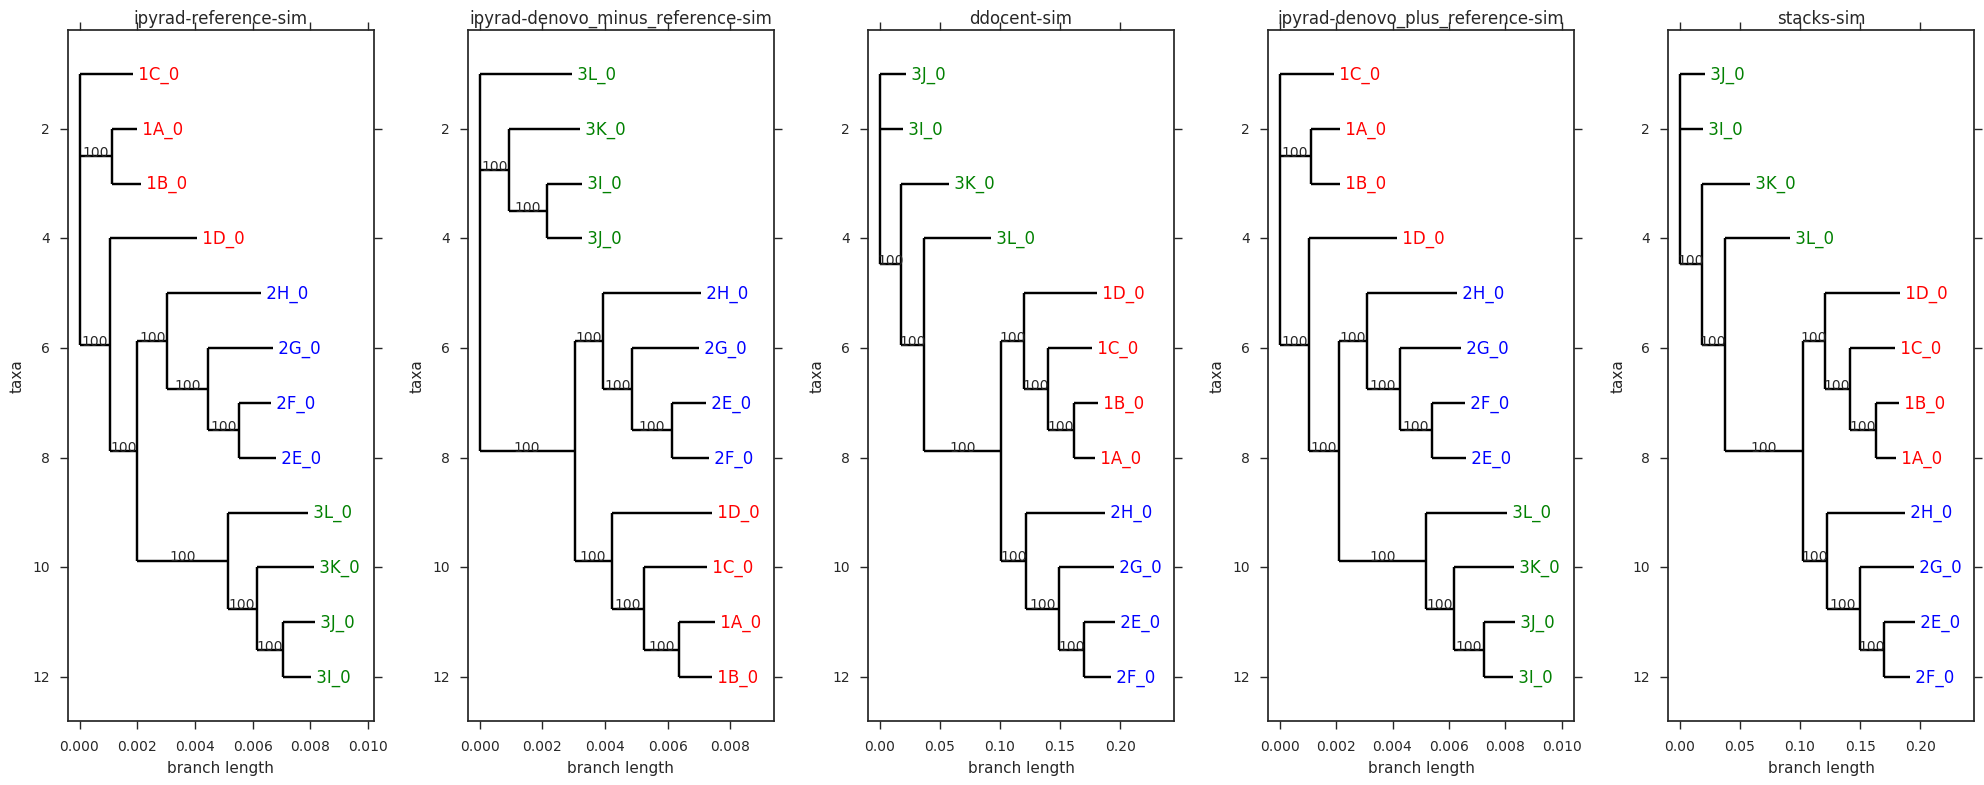

In [262]:
#!conda install biopython
from Bio import Phylo

f, axarr = plt.subplots(1, 5, figsize=(20,8), dpi=1000)

## For more than 1 row uncomment this
#axarr = [a for b in axarr for a in b]

## Pop membership and colors per pop were estabilshed above during the PCA
#sim_sample_names = pop1 + pop2 + pop3
#sim_pops = {"pop1":pop1, "pop2":pop2, "pop3":pop3}
#sim_pop_colors = {"pop1":"r", "pop2":"b", "pop3":"g"}
sim_colors_per_sample = {}
for samp in sim_sample_names:
    for pop in sim_pops:
        if samp in sim_pops[pop]:
            sim_colors_per_sample[samp] = sim_pop_colors[pop]

## Set them in order so the plot looks nice.
#progs = ["ipyrad-reference-sim", "ipyrad-denovo_plus_reference-sim", "ipyrad-denovo_minus_reference-sim", "stacks-sim", "ddocent-fin-sim",\
#         "ipyrad-reference-empirical", "ipyrad-denovo_reference-empirical", "ipyrad-denovo_minus_reference-empirical", "stacks-empirical", "ddocent-fin-empirical"]

for assembler, ax in zip(sim_trees.keys(), axarr):
    print(assembler, sim_trees[assembler], ax)
    tree = Phylo.read(sim_trees[assembler], 'newick')
    tree.ladderize()
    ## This could be cool but doesn't work
    Phylo.draw(tree, axes = ax, do_show=False, label_colors=sim_colors_per_sample)
    ax.set_title(assembler)
plt.tight_layout()

In [ ]:
## Set empirical colors
emp_colors_per_sample = {}
for samp in emp_sample_names:
    for pop in emp_pops:
        if samp in emp_pops[pop]:
            emp_colors_per_sample[samp] = emp_pop_colors[pop]

In [ ]:
import ete3

In [ ]:
for prog in all_calldata.keys():
#for prog in ["ipyrad-reference-sim"]:
    print("Doing {}".format(prog))
    try:
        c = all_calldata[prog]
        v = all_vardata[prog]
    except:
        print("Failed to load for {}".format(prog))
        continue
    ## Get only parsimony informative sites
    ## Get T/F values for whether each genotype is ref or alt across all samples/loci
    is_alt_allele = map(lambda x: map(lambda y: 1 in y, x), c["genotype"])
    ## Count the number of alt alleles per snp (we only want to retain when #alt > 1)
    alt_counts = map(lambda x: np.count_nonzero(x), is_alt_allele)
    ## Create a T/F mask for snps that are informative
    only_pis = map(lambda x: x < 2, alt_counts)
    ## Apply the mask to the variant array so we can pull out the position of each snp w/in each locus
    ## Also, compress() the masked array so we only actually see the pis
    pis = np.ma.array(np.array(v["POS"]), mask=only_pis).compressed()

    ## Now have to massage this into the list of counts per site in increasing order 
    ## of position across the locus
    distpis = Counter([int(x) for x in pis])
    #distpis = [x for x in sorted(counts.items())]

    ## Getting the distvar is easier
    distvar = Counter([int(x) for x in v.POS])
    #distvar = [x for x in sorted(counts.items())]

    canvas, axes = SNP_position_plot(prog, distvar, distpis)

    ## save fig
    #toyplot.html.render(canvas, 'snp_positions.html')

    canvas

Doing ipyrad-reference-sim
Doing ipyrad-denovo_reference-sim
Doing stacks-sim
Doing ddocent-simipyrad-reference-empirical
Failed to load for ddocent-simipyrad-reference-empirical
Doing ipyrad-denovo_reference-empirical
Failed to load for ipyrad-denovo_reference-empirical
Doing stacks-empirical
Doing ddocent-fin-empirical


<polygon points="65.0,235.0 68.602150537634415,235.0 72.204301075268816,235.0 75.806451612903231,235.0 79.408602150537632,235.0 83.010752688172047,235.0 86.612903225806448,235.0 90.215053763440864,235.0 93.817204301075265,235.0 97.41935483870968,235.0 101.02150537634409,235.0 104.6236559139785,235.0 108.2258064516129,235.0 111.82795698924731,235.0 115.43010752688173,235.0 119.03225806451613,235.0 122.63440860215054,235.0 126.23655913978493,235.0 129.83870967741936,235.0 133.44086021505376,235.0 137.04301075268816,235.0 140.64516129032259,235.0 144.24731182795699,235.0 147.84946236559139,235.0 151.45161290322579,235.0 155.05376344086022,235.0 158.65591397849462,235.0 162.25806451612902,235.0 165.86021505376345,235.0 169.46236559139786,235.0 173.06451612903226,235.0 176.66666666666669,235.0 180.26881720430109,235.0 183.87096774193549,235.0 187.47311827956989,235.0 191.07526881720429,235.0 194.67741935483869,235.0 198.27956989247309,235.0 201.88172043010752,235.0 205.48387096774195,235.0 209.08602150537632,235.0 212.68817204301075,235.0 216.29032258064515,235.0 219.89247311827955,235.0 223.49462365591398,235.0 227.09677419354841,235.0 230.69892473118279,235.0 234.30107526881721,235.0 237.90322580645159,235.0 241.50537634408602,235.0 245.10752688172042,235.0 248.70967741935482,235.0 252.31182795698925,235.0 255.91397849462368,235.0 259.51612903225811,235.0 263.11827956989248,235.0 266.72043010752691,235.0 270.32258064516128,235.0 273.92473118279571,235.0 277.52688172043014,235.0 281.12903225806451,235.0 284.73118279569894,235.0 288.33333333333331,235.0 291.93548387096774,235.0 295.53763440860217,235.0 299.13978494623655,235.0 302.74193548387098,235.0 306.34408602150535,235.0 309.94623655913978,235.0 313.54838709677421,235.0 317.15053763440864,235.0 320.75268817204301,235.0 324.35483870967738,235.0 327.95698924731181,235.0 331.55913978494618,235.0 335.16129032258067,235.0 338.76344086021504,235.0 342.36559139784947,235.0 345.9677419354839,235.0 349.56989247311827,235.0 353.1720430107527,235.0 356.77419354838707,235.0 360.3763440860215,235.0 363.97849462365593,235.0 367.58064516129031,235.0 371.18279569892474,235.0 374.78494623655911,235.0 378.38709677419354,235.0 381.98924731182797,235.0 385.59139784946234,235.0 389.19354838709683,235.0 392.7956989247312,235.0 396.39784946236563,235.0 400.0,235.0 403.60215053763437,235.0 407.2043010752688,235.0 410.80645161290317,235.0 414.40860215053766,235.0 418.01075268817203,235.0 421.61290322580646,235.0 425.21505376344084,235.0 428.81720430107521,235.0 432.41935483870964,235.0 436.02150537634407,235.0 439.6236559139785,235.0 443.22580645161293,235.0 446.82795698924735,235.0 450.43010752688178,235.0 454.03225806451616,235.0 457.63440860215053,235.0 461.23655913978496,235.0 464.83870967741933,235.0 468.44086021505382,235.0 472.04301075268819,235.0 475.64516129032262,235.0 479.24731182795699,235.0 482.84946236559136,235.0 486.45161290322579,235.0 490.05376344086022,235.0 493.65591397849465,235.0 497.25806451612902,235.0 500.8602150537634,235.0 504.46236559139783,235.0 508.0645161290322,235.0 511.66666666666669,235.0 515.26881720430106,235.0 518.87096774193549,235.0 522.4731182795698,235.0 526.07526881720435,235.0 529.67741935483878,235.0 533.27956989247321,235.0 536.88172043010763,235.0 540.48387096774195,235.0 544.08602150537638,235.0 547.6881720430107,235.0 551.29032258064524,235.0 554.89247311827955,235.0 558.49462365591398,235.0 562.09677419354841,235.0 565.69892473118273,235.0 569.30107526881727,235.0 572.90322580645159,235.0 576.50537634408602,235.0 580.10752688172045,235.0 583.70967741935476,235.0 587.3118279569893,235.0 590.91397849462362,235.0 594.51612903225805,235.0 598.11827956989237,235.0 601.72043010752679,235.0 605.32258064516134,235.0 608.92473118279565,235.0 612.52688172043008,235.0 616.12903225806451,235.0 619.73118279569894,235.0 623.33333333333337,235.0 626.9354838709678,235.0 630.53763440860212,235.0 634.13978494623655,235.0 637.74193548387098,235.0 641.3440860215054,235.0 6

<polygon points="65.0,235.0 68.602150537634415,235.0 72.204301075268816,235.0 75.806451612903231,235.0 79.408602150537632,235.0 83.010752688172047,235.0 86.612903225806448,235.0 90.215053763440864,235.0 93.817204301075265,235.0 97.41935483870968,235.0 101.02150537634409,235.0 104.6236559139785,235.0 108.2258064516129,235.0 111.82795698924731,235.0 115.43010752688173,235.0 119.03225806451613,235.0 122.63440860215054,235.0 126.23655913978493,235.0 129.83870967741936,235.0 133.44086021505376,235.0 137.04301075268816,235.0 140.64516129032259,235.0 144.24731182795699,235.0 147.84946236559139,235.0 151.45161290322579,235.0 155.05376344086022,235.0 158.65591397849462,235.0 162.25806451612902,235.0 165.86021505376345,235.0 169.46236559139786,235.0 173.06451612903226,235.0 176.66666666666669,235.0 180.26881720430109,235.0 183.87096774193549,235.0 187.47311827956989,235.0 191.07526881720429,235.0 194.67741935483869,235.0 198.27956989247309,235.0 201.88172043010752,235.0 205.48387096774195,235.0 209.08602150537632,235.0 212.68817204301075,235.0 216.29032258064515,235.0 219.89247311827955,235.0 223.49462365591398,235.0 227.09677419354841,235.0 230.69892473118279,235.0 234.30107526881721,235.0 237.90322580645159,235.0 241.50537634408602,235.0 245.10752688172042,235.0 248.70967741935482,235.0 252.31182795698925,235.0 255.91397849462368,235.0 259.51612903225811,235.0 263.11827956989248,235.0 266.72043010752691,235.0 270.32258064516128,235.0 273.92473118279571,235.0 277.52688172043014,235.0 281.12903225806451,235.0 284.73118279569894,235.0 288.33333333333331,235.0 291.93548387096774,235.0 295.53763440860217,235.0 299.13978494623655,235.0 302.74193548387098,235.0 306.34408602150535,235.0 309.94623655913978,235.0 313.54838709677421,235.0 317.15053763440864,235.0 320.75268817204301,235.0 324.35483870967738,235.0 327.95698924731181,235.0 331.55913978494618,235.0 335.16129032258067,235.0 338.76344086021504,235.0 342.36559139784947,235.0 345.9677419354839,235.0 349.56989247311827,235.0 353.1720430107527,235.0 356.77419354838707,235.0 360.3763440860215,235.0 363.97849462365593,235.0 367.58064516129031,235.0 371.18279569892474,235.0 374.78494623655911,235.0 378.38709677419354,235.0 381.98924731182797,235.0 385.59139784946234,235.0 389.19354838709683,235.0 392.7956989247312,235.0 396.39784946236563,235.0 400.0,235.0 403.60215053763437,235.0 407.2043010752688,235.0 410.80645161290317,235.0 414.40860215053766,235.0 418.01075268817203,235.0 421.61290322580646,235.0 425.21505376344084,235.0 428.81720430107521,235.0 432.41935483870964,235.0 436.02150537634407,235.0 439.6236559139785,235.0 443.22580645161293,235.0 446.82795698924735,235.0 450.43010752688178,235.0 454.03225806451616,235.0 457.63440860215053,235.0 461.23655913978496,235.0 464.83870967741933,235.0 468.44086021505382,235.0 472.04301075268819,235.0 475.64516129032262,235.0 479.24731182795699,235.0 482.84946236559136,235.0 486.45161290322579,235.0 490.05376344086022,235.0 493.65591397849465,235.0 497.25806451612902,235.0 500.8602150537634,235.0 504.46236559139783,235.0 508.0645161290322,235.0 511.66666666666669,235.0 515.26881720430106,235.0 518.87096774193549,235.0 522.4731182795698,235.0 526.07526881720435,235.0 529.67741935483878,235.0 533.27956989247321,235.0 536.88172043010763,235.0 540.48387096774195,235.0 544.08602150537638,235.0 547.6881720430107,235.0 551.29032258064524,235.0 554.89247311827955,235.0 558.49462365591398,235.0 562.09677419354841,235.0 565.69892473118273,235.0 569.30107526881727,235.0 572.90322580645159,235.0 576.50537634408602,235.0 580.10752688172045,235.0 583.70967741935476,235.0 587.3118279569893,235.0 590.91397849462362,235.0 594.51612903225805,235.0 598.11827956989237,235.0 601.72043010752679,235.0 605.32258064516134,235.0 608.92473118279565,235.0 612.52688172043008,235.0 616.12903225806451,235.0 619.73118279569894,235.0 623.33333333333337,235.0 626.9354838709678,235.0 630.53763440860212,235.0 634.13978494623655,235.0 637.74193548387098,235.0 641.3440860215054,235.0 6

In [ ]:
## Checking out differences between 0.85 and 0.95 clustering threshold for ipyrad

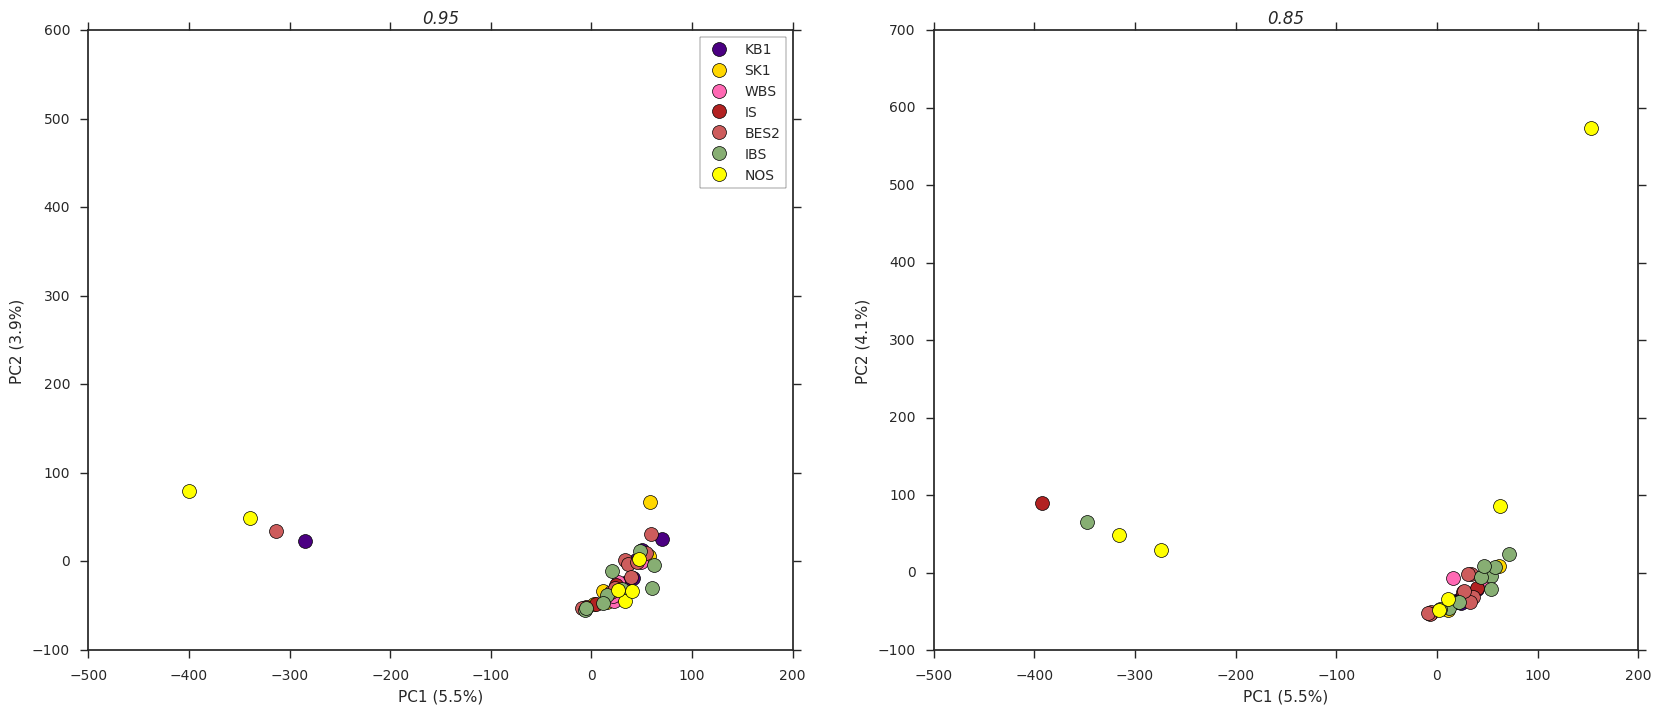

In [339]:
filename = "/home/iovercast/manuscript-analysis/Phocoena_empirical/ipyrad/reference-assembly/denovo_minus_reference-0.95_outfiles/denovo_ref-empirical.vcf"
## Only need to load once
#myv = vcfnp.variants(filename, verbose=False, dtypes={"CHROM":"a24"}).view(np.recarray)
#myc = vcfnp.calldata_2d(filename, verbose=False).view(np.recarray)

f, axarr = plt.subplots(1, 2, figsize=(20,8), dpi=1000)
## Make a list out of the axes
## Set them in order so the plot looks nice.
progs = ["ipyrad-reference-sim", "ipyrad-denovo_plus_reference-sim", "ipyrad-denovo_minus_reference-sim", "stacks-sim", "ddocent-fin-sim",\
         "ipyrad-reference-empirical", "ipyrad-denovo_reference-empirical", "ipyrad-denovo_minus_reference-empirical", "stacks-empirical", "ddocent-fin-empirical"]
rundict = {"0.85":all_calldata["ipyrad-denovo_minus_reference-empirical"], "0.95":myc}

for prog, ax in zip(rundict.keys(), axarr):
    pop_colors = emp_pop_colors
    pops = emp_pops
    sample_names = emp_sample_names

    ## Don't die if some of the runs aren't complete
    try:
        coords1, model1 = getPCA(rundict[prog])
    except:
        continue
        
    x = coords1[:, 0]
    y = coords1[:, 1]

    ax.scatter(x, y, marker='o')
    ax.set_xlabel('PC%s (%.1f%%)' % (1, model1.explained_variance_ratio_[0]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (2, model1.explained_variance_ratio_[1]*100))

    for pop in pops.keys():
        flt = np.in1d(np.array(sample_names), pops[pop])
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=pop_colors[pop], label=pop, markersize=10, mec='k', mew=.5)

    ax.set_title(prog, style="italic")
    ax.axison = True

axarr[0].legend(frameon=True)

In [329]:
def plot_ld(gn, title):
    m = allel.stats.rogers_huff_r(gn) ** 2
    ax = allel.plot.pairwise_ld(m)
    ax.set_title(title)
def ld_prune(gn, size=1000, step=1000, threshold=.3, n_iter=5):
    for i in range(n_iter):
        loc_unlinked = allel.stats.ld.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

In [293]:
g = allel.GenotypeArray(myc.genotype)
ac = g.count_alleles()
## Filter singletons and multi-allelic snps
flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
gf = g.compress(flt, axis=0)
gn = gf.to_n_alt()

In [303]:
gnu = ld_prune(gn, size=50, step=200, threshold=.1, n_iter=5)

('iteration', 1, 'retaining', 70451, 'removing', 12654, 'variants')
('iteration', 2, 'retaining', 60084, 'removing', 10367, 'variants')
('iteration', 3, 'retaining', 51456, 'removing', 8628, 'variants')
('iteration', 4, 'retaining', 44316, 'removing', 7140, 'variants')
('iteration', 5, 'retaining', 38444, 'removing', 5872, 'variants')


In [ ]:
coords1, model1 = allel.pca(gnu, n_components=10, scaler='patterson')